<a href="https://colab.research.google.com/github/HFooladi/GNNs-For-Chemists/blob/main/notebooks/06_GNN_GIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Isomorphism Networks (GIN) Tutorial for Chemists and Pharmacists

## Table of Contents
1. [Introduction](#introduction)
2. [Setup and Installation](#setup-and-installation)
3. [Understanding Molecular Graphs and Isomorphism](#understanding-molecular-graphs-and-isomorphism)
4. [The Theory Behind Graph Isomorphism Networks (GIN)](#theory-behind-gin)
5. [Implementing a GIN Model for Molecules](#implementing-a-gin-model-for-molecules)
6. [Training GIN for Molecular Property Prediction](#training-gin-for-molecular-property-prediction)
7. [VGIN for Molecular Fingerprinting](#gin-for-molecular-fingerprinting)
8. [Analyzing Isomorphic vs. Non-Isomorphic Molecule Pairs](#analyzing-isomorphic-vs-non-isomorphic-molecule-pairs)
9. [Interpreting GIN Embeddings for Chemical Insights](#interpreting-gin-embeddings-for-chemical-insights)
10. [Ablation Studies: Understanding GIN Components](#ablation-studies-understanding-gin-components)
11. [Practical Applications in Drug Discovery](#practical-applications-in-drug-discovery)
12. [Conclusion and Best Practices](#conclusion-and-best-practices)


## 1. Introduction <a name="introduction"></a>

Graph Isomorphism Networks (GINs) are a powerful class of Graph Neural Networks designed to maximize the discriminative power when differentiating graph structures. This makes them particularly valuable for molecular applications, where subtle structural differences between molecules can lead to completely different chemical properties.

In this tutorial, we'll explore GINs with a specific focus on:
1. Understanding the theoretical foundations of GINs and their discriminative power
2. Implementing GINs for molecular property prediction
3. Using GINs for molecular fingerprinting and similarity search
4. Comparing GIN performance with other GNN architectures (GCN, GAT)

## 2. Setup and Installation <a name="setup-and-installation"></a>

First, let's install the necessary packages:

In [ ]:
#@title Intstall necessary libraries
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q rdkit
!pip install -q networkx

2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 15.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 35.4 MB/s eta 0:00:00


In [ ]:
#@title Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv, GCNConv, GATConv
from torch_geometric.nn import global_add_pool, global_max_pool, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.datasets import MoleculeNet
from torch_geometric.utils import to_networkx

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import rdMolDraw2D
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
import io
from PIL import Image
import random
from IPython.display import HTML

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 3. Understanding Molecular Graphs and Isomorphism <a name="understanding-molecular-graphs-and-isomorphism"></a>

Before diving into GINs, let's first understand what graph isomorphism means in the context of molecular graphs.

Isomorphic Molecules (Same Structure, Different Representation):

2-methylbutane - CC(C)CC


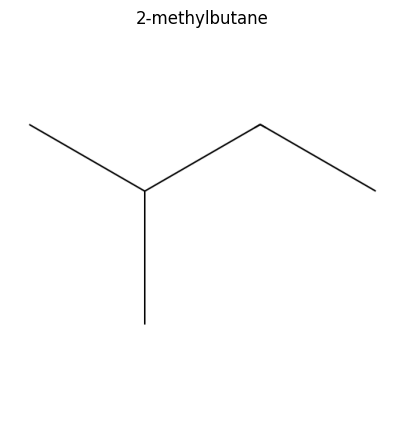

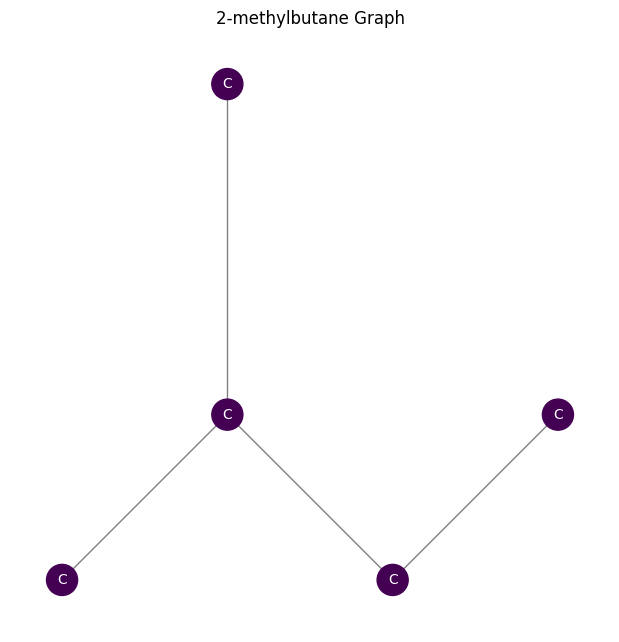


isopentane - CCC(C)C


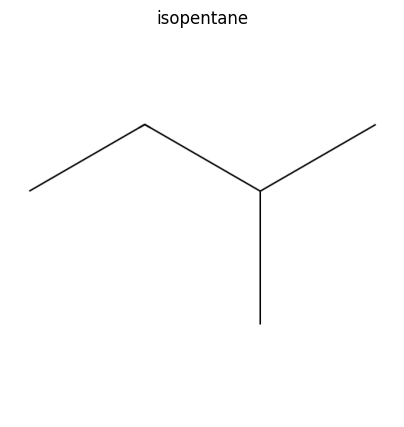

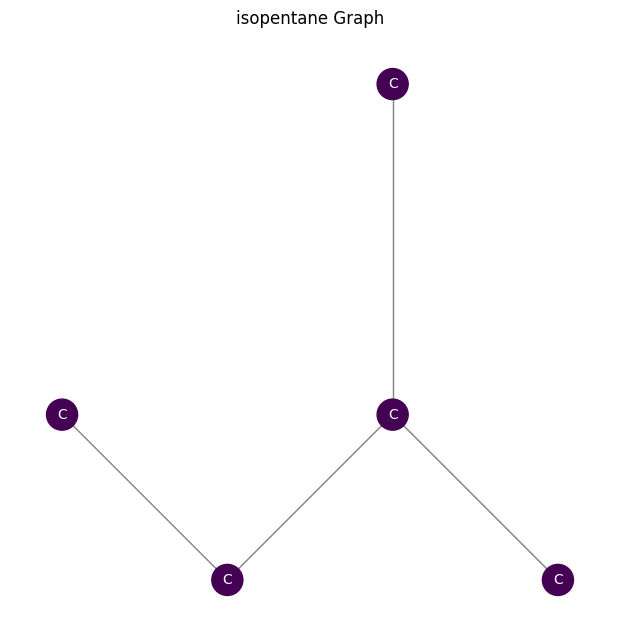


Non-isomorphic Molecules (Different Structures):

n-pentane - CCCCC


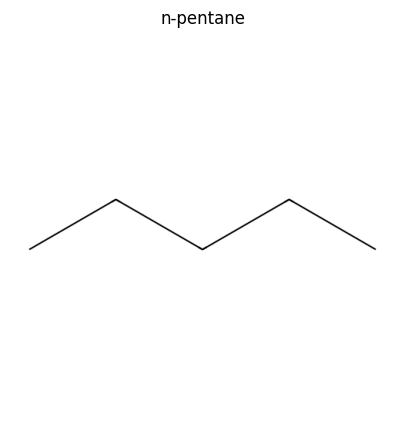

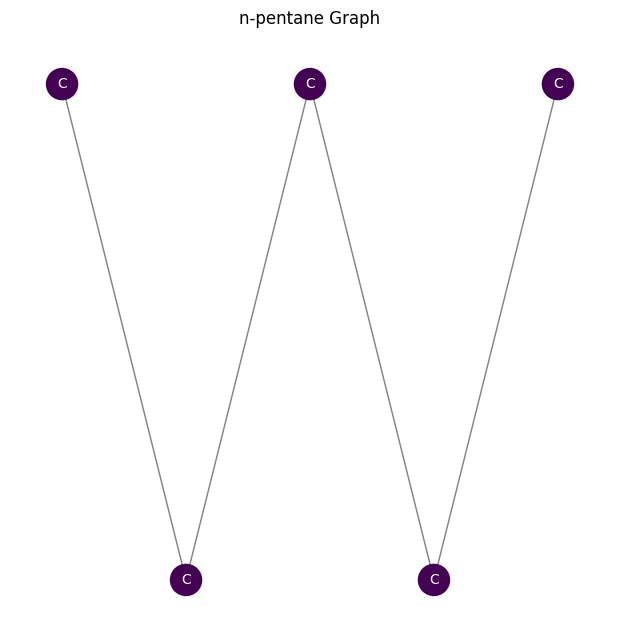


2-methylbutane - CC(C)CC


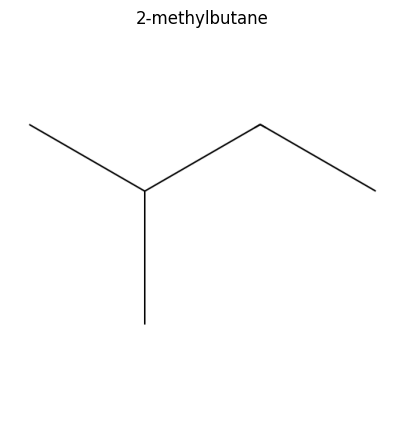

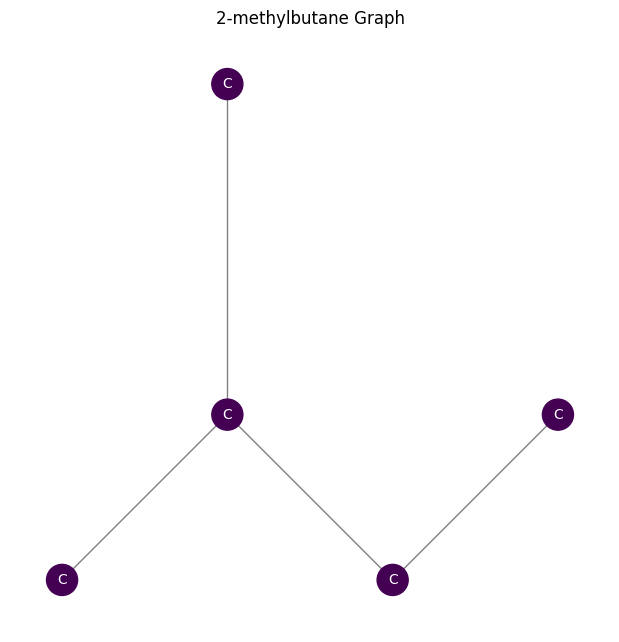

In [ ]:
def atom_features(atom):
    """
    Extract a feature vector for an RDKit atom.

    Features included:
        - Atomic number
        - Chirality tag (encoded as integer)
        - Degree (number of directly-bonded atoms)
        - Formal charge
        - Total number of hydrogens
        - Number of radical electrons
        - Hybridization (encoded as integer)
        - Aromaticity (0 or 1)
        - Ring membership (0 or 1)

    Args:
        atom (rdkit.Chem.rdchem.Atom): An RDKit Atom object.

    Returns:
        torch.Tensor: Feature tensor of shape (9,) with dtype long.
    """
    return torch.tensor([
        atom.GetAtomicNum(),                    # Atomic number
        int(atom.GetChiralTag()),               # Chirality
        atom.GetDegree(),                       # Degree
        atom.GetFormalCharge(),                 # Formal charge
        atom.GetTotalNumHs(),                   # Number of hydrogens
        atom.GetNumRadicalElectrons(),          # Radical electrons
        int(atom.GetHybridization()),           # Hybridization
        int(atom.GetIsAromatic()),              # Aromaticity
        int(atom.IsInRing())                    # Ring membership
    ], dtype=torch.long)


def bond_features(bond):
    """
    Extract a feature vector for an RDKit bond.

    Features included:
        - Bond type as double (e.g., 1.0 for single, 2.0 for double)
        - Conjugation (0 or 1)
        - Ring membership (0 or 1)

    Args:
        bond (rdkit.Chem.rdchem.Bond): An RDKit Bond object.

    Returns:
        torch.Tensor: Feature tensor of shape (3,) with dtype long.
    """
    return torch.tensor([
        int(bond.GetBondTypeAsDouble()),        # Bond type
        int(bond.GetIsConjugated()),            # Conjugation
        int(bond.IsInRing())                    # Ring membership
    ], dtype=torch.long)

def mol_to_graph(smiles):
    """
    Converts a SMILES into a PyTorch Geometric graph data object.

    Nodes represent atoms with features, and edges represent bonds with features.
    The graph is undirected: each bond adds two directed edges (i->j and j->i).

    Args:
        smiles (str): SMILES representing the molecule.

    Returns:
        torch_geometric.data.Data: Graph data object containing:
            - x: Node feature matrix [num_nodes, 9]
            - edge_index: Edge list [2, num_edges]
            - edge_attr: Edge feature matrix [num_edges, 3]
            - smiles: Original SMILES
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")

    # Node features
    x = torch.stack([atom_features(atom) for atom in mol.GetAtoms()], dim=0)

    # Edge index and edge features
    edge_index = []
    edge_attr = []

    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        # Add both directions for undirected graph
        edge_index.append((i, j))
        edge_index.append((j, i))

        edge_attr.append(bond_features(bond))
        edge_attr.append(bond_features(bond))

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.stack(edge_attr, dim=0) if edge_attr else None

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, smiles=smiles)
    return data


def visualize_molecule(smiles, title="Molecule"):
    """Visualize a molecule using RDKit"""
    mol = Chem.MolFromSmiles(smiles)
    AllChem.Compute2DCoords(mol)

    # Draw molecule
    fig, ax = plt.subplots(figsize=(5, 5))
    drawer = rdMolDraw2D.MolDraw2DCairo(500, 500)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    img = drawer.GetDrawingText()

    # Convert the image data to a PIL Image
    pil_image = Image.open(io.BytesIO(img))

    # Display the image
    plt.imshow(pil_image)
    plt.axis('off')
    plt.title(title)
    plt.show()

def visualize_molecular_graph(smiles, title="Molecular Graph"):
    """
    Visualizes the 2D structure of a molecule using RDKit and networkx and displays it.

    Args:
        smiles (str): SMILES representing the molecule.
        title (str): Plot title.
    """
    mol = Chem.MolFromSmiles(smiles)
    AllChem.Compute2DCoords(mol)

    data = mol_to_graph(smiles)
    G = to_networkx(data, to_undirected=True)

    # Get the 2D coordinates from RDKit
    pos = {}
    for i, atom in enumerate(mol.GetAtoms()):
        pos[i] = mol.GetConformer().GetAtomPosition(i)
        pos[i] = (pos[i].x, -pos[i].y)  # Flip y for better visualization

    plt.figure(figsize=(6, 6))

    # Get atom labels
    atom_labels = {i: atom.GetSymbol() for i, atom in enumerate(mol.GetAtoms())}

    # Get atom features for node coloring
    atom_features = [atom.GetAtomicNum() for atom in mol.GetAtoms()]

    # Draw the graph
    nx.draw(G, pos,
            labels=atom_labels,
            with_labels=True,
            node_color=atom_features,
            cmap=plt.cm.viridis,
            node_size=500,
            font_size=10,
            font_color='white',
            edge_color='gray')

    plt.title(title)
    plt.axis('off')
    plt.show()

# Let's understand isomorphism with some examples
isomorphic_pair = {
    "2-methylbutane": "CC(C)CC",
    "isopentane": "CCC(C)C"
}

non_isomorphic_pair = {
    "n-pentane": "CCCCC",
    "2-methylbutane": "CC(C)CC"
}

# Visualize isomorphic molecules
print("Isomorphic Molecules (Same Structure, Different Representation):")
for name, smiles in isomorphic_pair.items():
    print(f"\n{name} - {smiles}")
    visualize_molecule(smiles, f"{name}")
    visualize_molecular_graph(smiles, f"{name} Graph")

# Visualize non-isomorphic molecules
print("\nNon-isomorphic Molecules (Different Structures):")
for name, smiles in non_isomorphic_pair.items():
    print(f"\n{name} - {smiles}")
    visualize_molecule(smiles, f"{name}")
    visualize_molecular_graph(smiles, f"{name} Graph")

### 3.1 Understanding Graph Isomorphism and WL Test


/tmp/ipykernel_477057/352814627.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


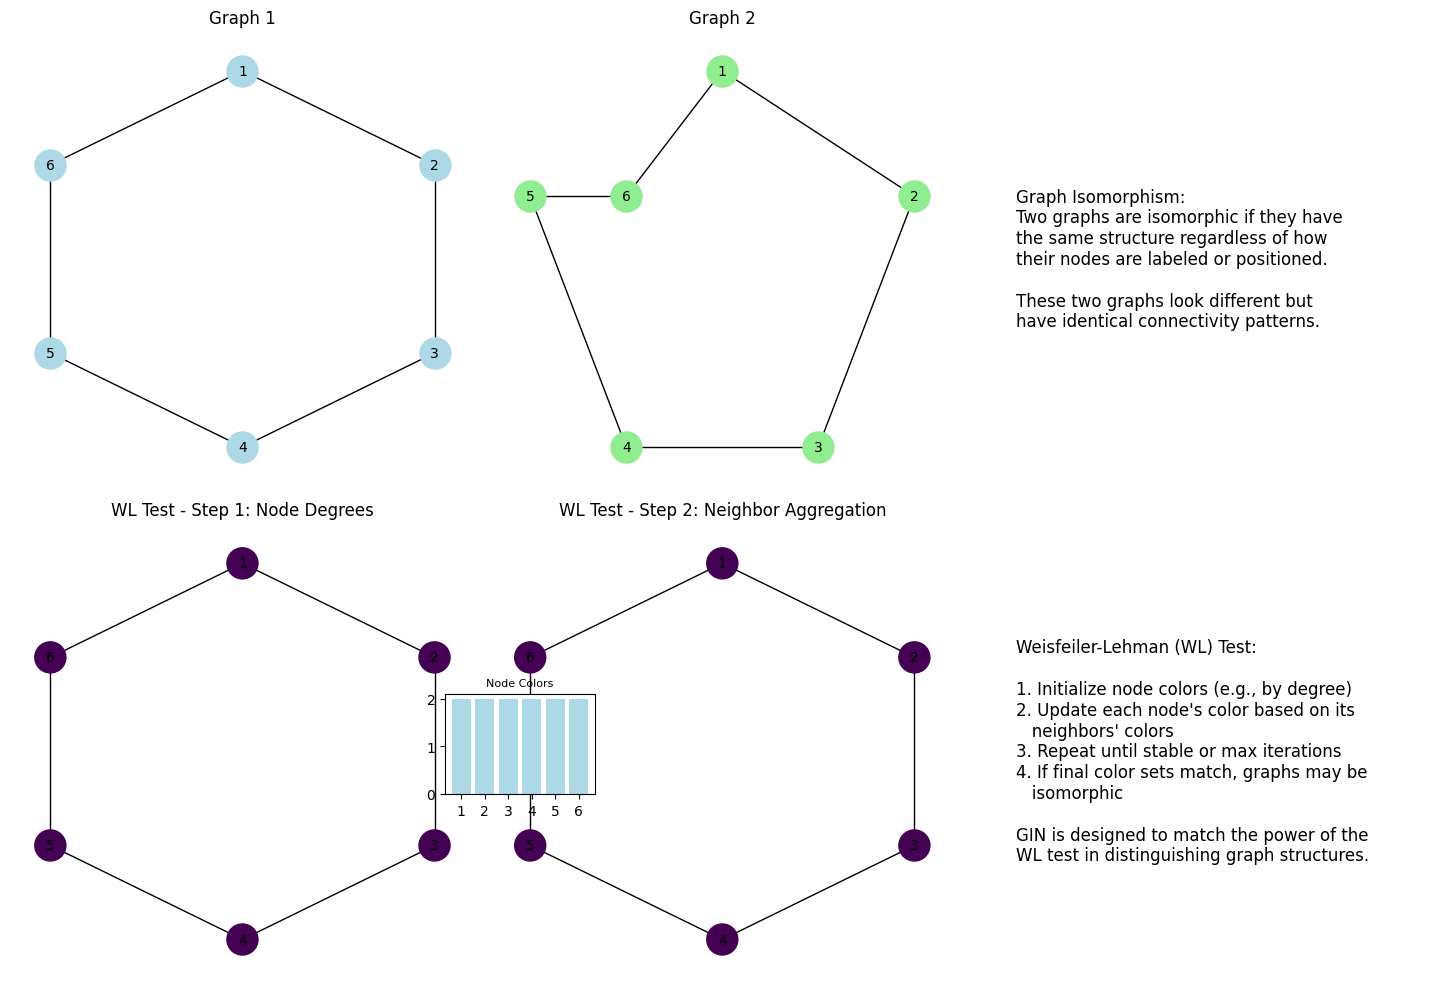

In [ ]:
def visualize_isomorphism_concept():
    """Create a visual explanation of graph isomorphism and the WL test"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Create two isomorphic graphs
    G1 = nx.Graph()
    G1.add_nodes_from(range(1, 7))
    G1.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 1)])

    G2 = nx.Graph()
    G2.add_nodes_from(range(1, 7))
    G2.add_edges_from([(1, 6), (6, 5), (5, 4), (4, 3), (3, 2), (2, 1)])

    # Different node positioning to make them look different
    pos1 = {
        1: (0, 1),
        2: (0.866, 0.5),
        3: (0.866, -0.5),
        4: (0, -1),
        5: (-0.866, -0.5),
        6: (-0.866, 0.5)
    }

    pos2 = {
        1: (0, 1),
        2: (1, 0.5),
        3: (0.5, -0.5),
        4: (-0.5, -0.5),
        5: (-1, 0.5),
        6: (-0.5, 0.5)
    }

    # Draw the original graphs
    ax = axes[0, 0]
    nx.draw(G1, pos1, with_labels=True, node_color='lightblue', node_size=500, font_size=10, ax=ax)
    ax.set_title("Graph 1")

    ax = axes[0, 1]
    nx.draw(G2, pos2, with_labels=True, node_color='lightgreen', node_size=500, font_size=10, ax=ax)
    ax.set_title("Graph 2")

    # Create empty subplot for text
    ax = axes[0, 2]
    ax.axis('off')
    ax.text(0.1, 0.5, "Graph Isomorphism:\nTwo graphs are isomorphic if they have\nthe same structure regardless of how\ntheir nodes are labeled or positioned.\n\nThese two graphs look different but\nhave identical connectivity patterns.",
            fontsize=12, ha='left', va='center')

    # Now visualize WL test iterations
    # Iteration 1: Initialize with degree
    wl_colors1 = {n: G1.degree(n) for n in G1.nodes()}
    wl_colors2 = {n: G2.degree(n) for n in G2.nodes()}

    # Draw WL test step 1
    ax = axes[1, 0]
    nx.draw(G1, pos1, with_labels=True,
            node_color=[wl_colors1[n] for n in G1.nodes()],
            cmap=plt.cm.viridis,
            node_size=500, font_size=10, ax=ax)
    ax.set_title("WL Test - Step 1: Node Degrees")

    # Draw inset with color mapping
    inset_ax = fig.add_axes([0.3, 0.2, 0.1, 0.1])
    inset_ax.bar(wl_colors1.keys(), wl_colors1.values(), color='lightblue')
    inset_ax.set_xticks(list(wl_colors1.keys()))
    inset_ax.set_title("Node Colors", fontsize=8)

    # Iteration 2: Update with neighbor colors
    def wl_update(graph, colors):
        new_colors = {}
        for node in graph.nodes():
            # Get colors of neighbors
            neighbor_colors = [colors[neigh] for neigh in graph.neighbors(node)]
            # Sort for canonical representation
            neighbor_colors.sort()
            # Create new color from node color and neighbor colors
            new_colors[node] = (colors[node], tuple(neighbor_colors))
        return new_colors

    wl_colors1_step2 = wl_update(G1, wl_colors1)
    wl_colors2_step2 = wl_update(G2, wl_colors2)

    # Convert to integers for visualization
    unique_colors = list(set(wl_colors1_step2.values()))
    color_map = {color: i for i, color in enumerate(unique_colors)}

    mapped_colors1 = {n: color_map[wl_colors1_step2[n]] for n in G1.nodes()}
    mapped_colors2 = {n: color_map[wl_colors2_step2[n]] for n in G2.nodes()}

    # Draw WL test step 2
    ax = axes[1, 1]
    nx.draw(G1, pos1, with_labels=True,
            node_color=[mapped_colors1[n] for n in G1.nodes()],
            cmap=plt.cm.viridis,
            node_size=500, font_size=10, ax=ax)
    ax.set_title("WL Test - Step 2: Neighbor Aggregation")

    # Create empty subplot for WL explanation
    ax = axes[1, 2]
    ax.axis('off')
    ax.text(0.1, 0.5, "Weisfeiler-Lehman (WL) Test:\n\n1. Initialize node colors (e.g., by degree)\n2. Update each node's color based on its\n   neighbors' colors\n3. Repeat until stable or max iterations\n4. If final color sets match, graphs may be\n   isomorphic\n\nGIN is designed to match the power of the\nWL test in distinguishing graph structures.",
            fontsize=12, ha='left', va='center')

    plt.tight_layout()
    plt.show()

# Visualize the concept of graph isomorphism and the WL test
visualize_isomorphism_concept()

## 4. The Theory Behind Graph Isomorphism Networks (GIN) <a name="theory-behind-gin"></a>

GIN was designed to have the same discriminative power as the Weisfeiler-Lehman (WL) graph isomorphism test, which is a powerful approach for distinguishing non-isomorphic graphs.


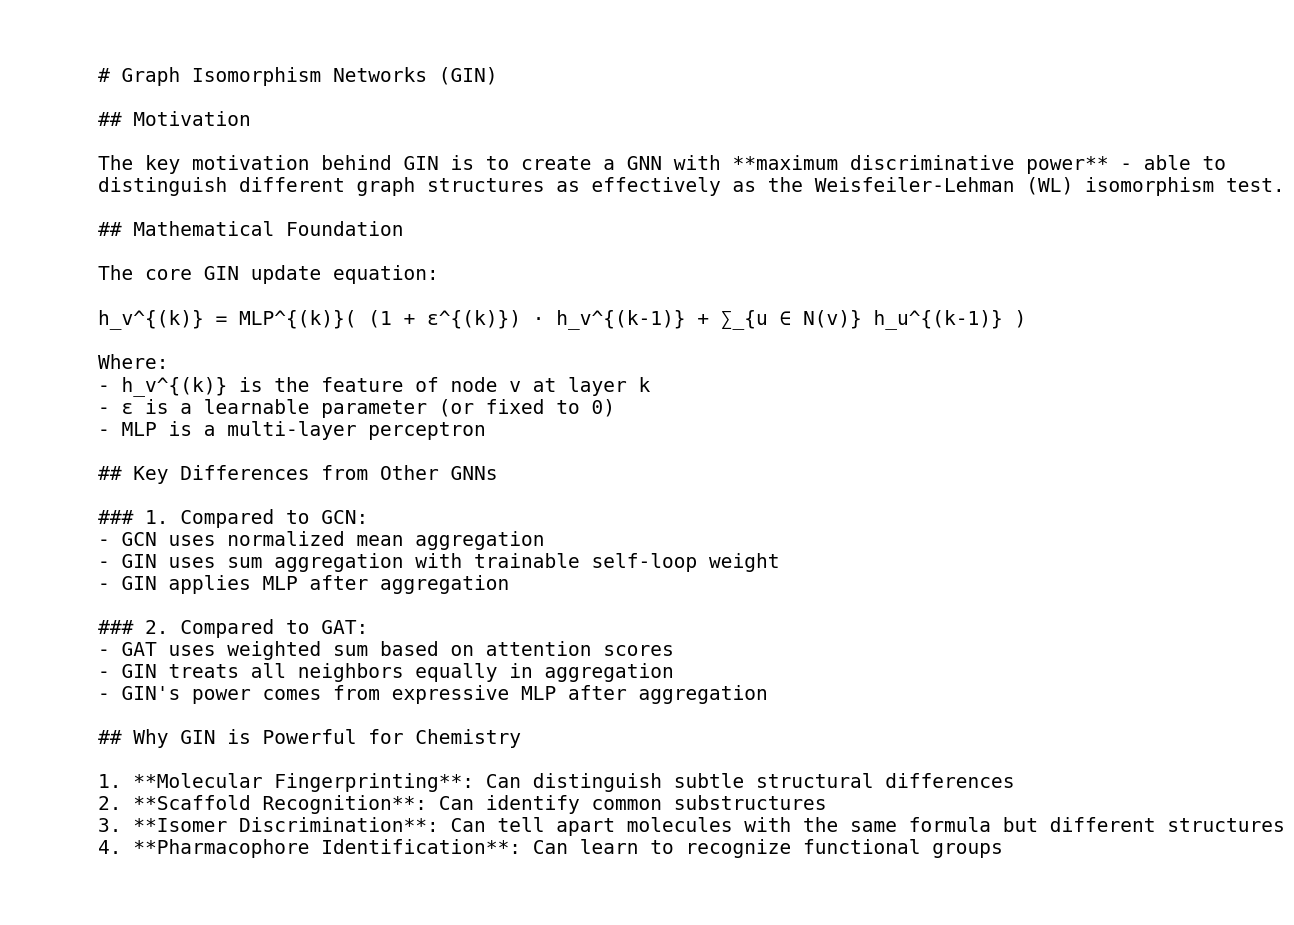

/tmp/ipykernel_477057/3771903850.py:95: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=edge_widths[i], alpha=0.7, ax=ax)


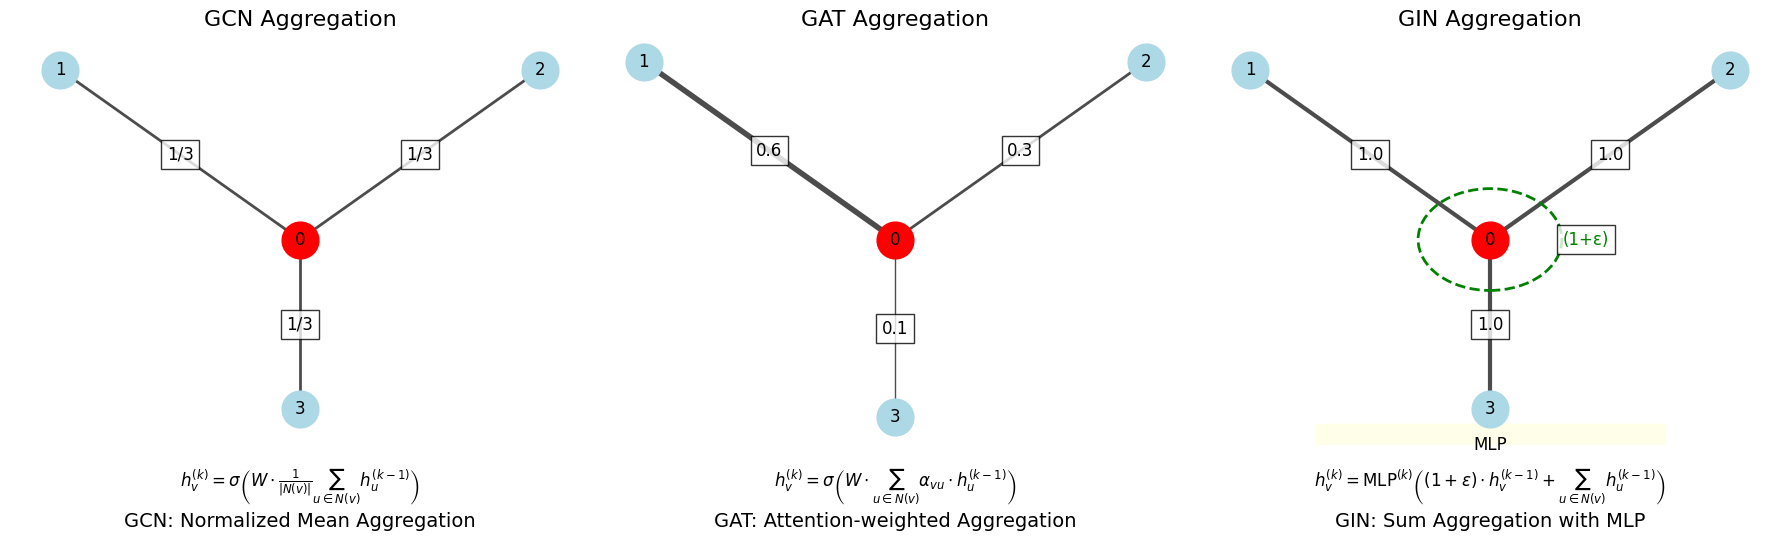

In [ ]:
def explain_gin_vs_other_gnns():
    """Create a visual explanation of how GIN differs from other GNNs"""
    plt.figure(figsize=(12, 10))

    # Define example text
    gin_explanation = """
    # Graph Isomorphism Networks (GIN)

    ## Motivation

    The key motivation behind GIN is to create a GNN with **maximum discriminative power** - able to
    distinguish different graph structures as effectively as the Weisfeiler-Lehman (WL) isomorphism test.

    ## Mathematical Foundation

    The core GIN update equation:

    h_v^{(k)} = MLP^{(k)}( (1 + ε^{(k)}) · h_v^{(k-1)} + ∑_{u ∈ N(v)} h_u^{(k-1)} )

    Where:
    - h_v^{(k)} is the feature of node v at layer k
    - ε is a learnable parameter (or fixed to 0)
    - MLP is a multi-layer perceptron

    ## Key Differences from Other GNNs

    ### 1. Compared to GCN:
    - GCN uses normalized mean aggregation
    - GIN uses sum aggregation with trainable self-loop weight
    - GIN applies MLP after aggregation

    ### 2. Compared to GAT:
    - GAT uses weighted sum based on attention scores
    - GIN treats all neighbors equally in aggregation
    - GIN's power comes from expressive MLP after aggregation

    ## Why GIN is Powerful for Chemistry

    1. **Molecular Fingerprinting**: Can distinguish subtle structural differences
    2. **Scaffold Recognition**: Can identify common substructures
    3. **Isomer Discrimination**: Can tell apart molecules with the same formula but different structures
    4. **Pharmacophore Identification**: Can learn to recognize functional groups
    """

    plt.text(0.05, 0.5, gin_explanation, fontsize=14,
            verticalalignment='center', horizontalalignment='left',
            family='monospace', transform=plt.gca().transAxes)

    plt.axis('off')
    plt.tight_layout()
    plt.show()

explain_gin_vs_other_gnns()

def visualize_gnn_aggregation_comparison():
    """Compare aggregation mechanisms in different GNNs"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Create a simple graph for demonstration
    G = nx.Graph()
    G.add_nodes_from([0, 1, 2, 3])
    G.add_edges_from([(0, 1), (0, 2), (0, 3)])

    # Define positions
    pos = {0: (0.5, 0.5), 1: (0, 1), 2: (1, 1), 3: (0.5, 0)}

    # GCN - Mean aggregation
    ax = axes[0]
    nx.draw_networkx_nodes(G, pos, nodelist=[0], node_color='red', node_size=700, ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=[1, 2, 3], node_color='lightblue', node_size=700, ax=ax)
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.7, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=12, ax=ax)

    # Add explanation text
    ax.text(0.5, -0.1, r"$h_v^{(k)} = \sigma\left(W \cdot \frac{1}{|N(v)|} \sum_{u \in N(v)} h_u^{(k-1)}\right)$",
            ha='center', fontsize=12, transform=ax.transAxes)
    ax.text(0.5, -0.2, "GCN: Normalized Mean Aggregation", ha='center', fontsize=14, transform=ax.transAxes)

    # Add coefficients
    ax.text(0.25, 0.75, "1/3", ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    ax.text(0.75, 0.75, "1/3", ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    ax.text(0.5, 0.25, "1/3", ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    ax.set_title("GCN Aggregation", fontsize=16)
    ax.axis('off')

    # GAT - Attention-weighted aggregation
    ax = axes[1]
    nx.draw_networkx_nodes(G, pos, nodelist=[0], node_color='red', node_size=700, ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=[1, 2, 3], node_color='lightblue', node_size=700, ax=ax)

    # Draw edges with different widths to represent attention
    edge_widths = [4, 2, 1]
    for i, (u, v) in enumerate([(0, 1), (0, 2), (0, 3)]):
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=edge_widths[i], alpha=0.7, ax=ax)

    nx.draw_networkx_labels(G, pos, font_size=12, ax=ax)

    # Add explanation text
    ax.text(0.5, -0.1, r"$h_v^{(k)} = \sigma\left(W \cdot \sum_{u \in N(v)} \alpha_{vu} \cdot h_u^{(k-1)}\right)$",
            ha='center', fontsize=12, transform=ax.transAxes)
    ax.text(0.5, -0.2, "GAT: Attention-weighted Aggregation", ha='center', fontsize=14, transform=ax.transAxes)

    # Add coefficients
    ax.text(0.25, 0.75, "0.6", ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    ax.text(0.75, 0.75, "0.3", ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    ax.text(0.5, 0.25, "0.1", ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    ax.set_title("GAT Aggregation", fontsize=16)
    ax.axis('off')

    # GIN - Sum aggregation with MLP
    ax = axes[2]
    nx.draw_networkx_nodes(G, pos, nodelist=[0], node_color='red', node_size=700, ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=[1, 2, 3], node_color='lightblue', node_size=700, ax=ax)
    nx.draw_networkx_edges(G, pos, width=3, alpha=0.7, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=12, ax=ax)

    # Add explanation text
    ax.text(0.5, -0.1, r"$h_v^{(k)} = \text{MLP}^{(k)}\left((1 + \epsilon) \cdot h_v^{(k-1)} + \sum_{u \in N(v)} h_u^{(k-1)}\right)$",
            ha='center', fontsize=12, transform=ax.transAxes)
    ax.text(0.5, -0.2, "GIN: Sum Aggregation with MLP", ha='center', fontsize=14, transform=ax.transAxes)

    # Add coefficients and highlight MLP
    ax.text(0.25, 0.75, "1.0", ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    ax.text(0.75, 0.75, "1.0", ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    ax.text(0.5, 0.25, "1.0", ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    # Add self-loop
    circle = plt.Circle((0.5, 0.5), 0.15, fill=False, linestyle='--', color='green', linewidth=2)
    ax.add_patch(circle)
    ax.text(0.7, 0.5, f"(1+ε)", ha='center', va='center', fontsize=12, color='green',
            bbox=dict(facecolor='white', alpha=0.8))

    # Add MLP
    rect = plt.Rectangle((0.2, -0.05), 0.6, 0.1, fill=True, color='lightyellow', alpha=0.7, transform=ax.transAxes)
    ax.add_patch(rect)
    ax.text(0.5, 0.0, "MLP", ha='center', va='center', fontsize=12, transform=ax.transAxes)

    ax.set_title("GIN Aggregation", fontsize=16)
    ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)
    plt.show()

# Compare the aggregation mechanisms of different GNNs
visualize_gnn_aggregation_comparison()

## 5. Implementing a GIN Model for Molecules <a name="implementing-a-gin-model-for-molecules"></a>

Now, let's implement a GIN model for molecular property prediction:

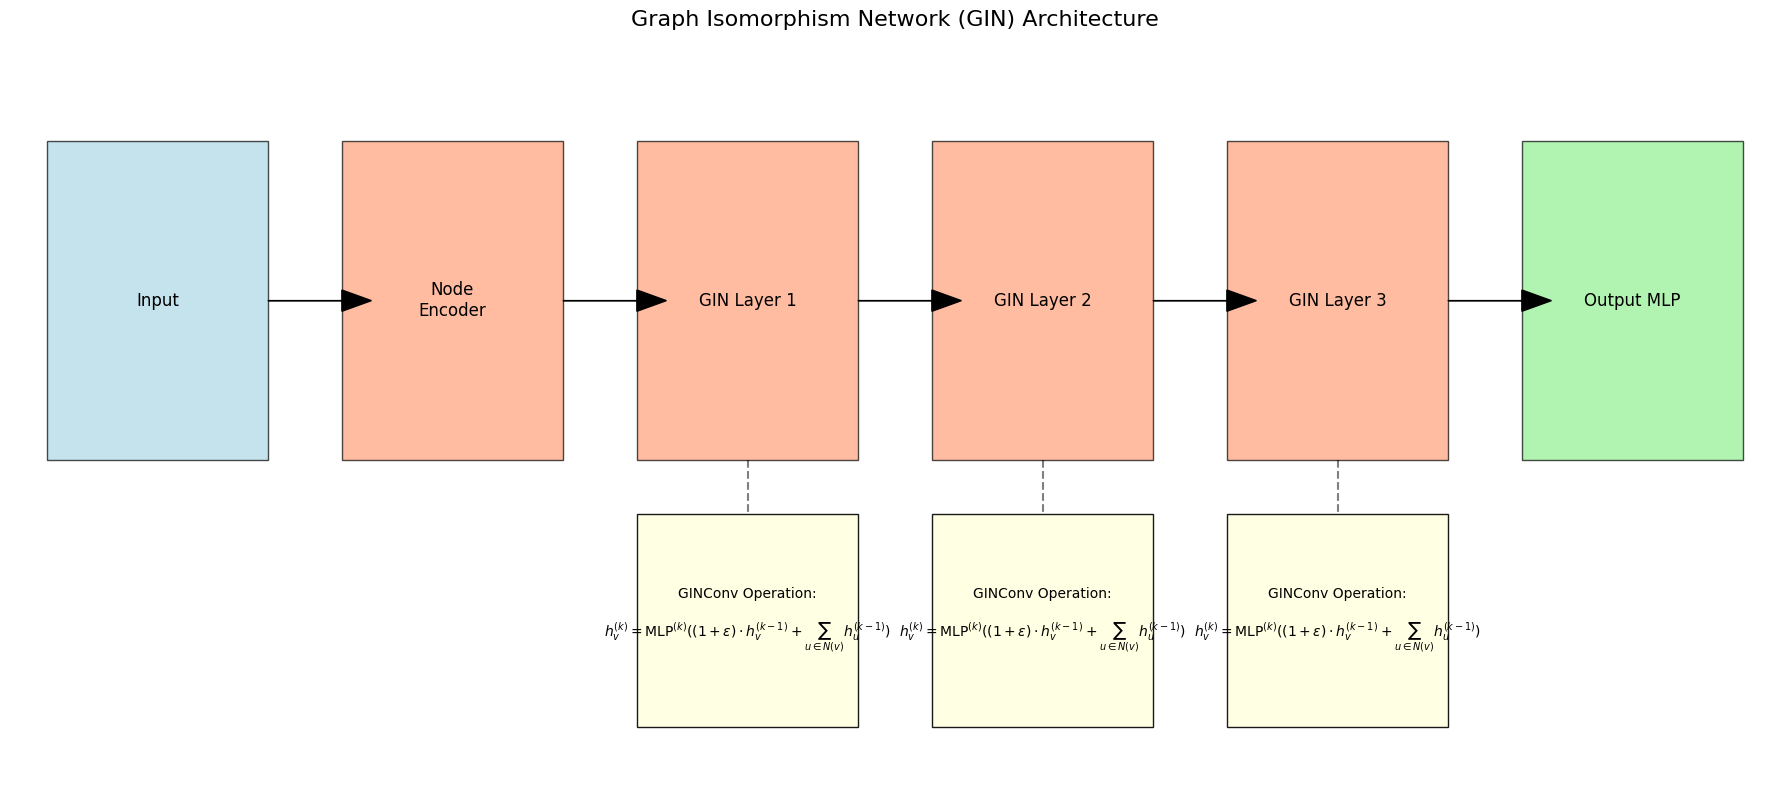

In [ ]:
class MLP(nn.Module):
    """
    Multi-layer Perceptron (MLP) implementation for GIN.
    This MLP is used both in the GINConv layers and for final predictions.

    Args:
        in_channels (int): Number of input features
        hidden_channels (int): Number of hidden features in intermediate layers
        out_channels (int): Number of output features
        num_layers (int, optional): Number of layers in the MLP. Default: 2

    The MLP consists of:
    - Linear layers with ReLU activation
    - Batch normalization (except for single layer case)
    - No activation on the final layer
    """
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2):
        super(MLP, self).__init__()
        self.lins = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        if num_layers == 1:
            # If single layer, don't use batch norm
            self.lins.append(nn.Linear(in_channels, out_channels))
        else:
            self.lins.append(nn.Linear(in_channels, hidden_channels))
            self.batch_norms.append(nn.BatchNorm1d(hidden_channels))

            for _ in range(num_layers - 2):
                self.lins.append(nn.Linear(hidden_channels, hidden_channels))
                self.batch_norms.append(nn.BatchNorm1d(hidden_channels))

            self.lins.append(nn.Linear(hidden_channels, out_channels))

    def forward(self, x):
        for i, lin in enumerate(self.lins[:-1]):
            x = lin(x)
            x = self.batch_norms[i](x)
            x = F.relu(x)
        x = self.lins[-1](x)
        return x

class GIN(nn.Module):
    """
    Graph Isomorphism Network (GIN) implementation.
    GIN is a powerful graph neural network architecture that can distinguish between different graph structures.

    Args:
        in_channels (int): Number of input node features
        hidden_channels (int): Number of hidden features
        out_channels (int): Number of output features
        num_layers (int, optional): Number of GIN layers. Default: 3
        dropout (float, optional): Dropout probability. Default: 0.5
        epsilon (float, optional): Initial value for learnable epsilon in GINConv. Default: 0

    The architecture consists of:
    1. Initial node feature projection
    2. Multiple GIN layers with MLPs
    3. Global mean pooling
    4. Final prediction MLP
    """
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3, dropout=0.5, epsilon=0):
        super(GIN, self).__init__()

        self.num_layers = num_layers
        self.dropout = dropout

        # Initial projection of node features
        self.node_encoder = nn.Linear(in_channels, hidden_channels)

        # GIN convolution layers
        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            mlp = MLP(hidden_channels, hidden_channels, hidden_channels)
            # epsilon can be learned or fixed
            self.convs.append(GINConv(mlp, train_eps=True, eps=epsilon))

        # Batch normalization layers
        self.batch_norms = nn.ModuleList([nn.BatchNorm1d(hidden_channels) for _ in range(num_layers)])

        # Prediction MLP
        self.mlp = MLP(hidden_channels, hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        """
        Forward pass of the GIN model.

        Args:
            x (torch.Tensor): Input node features
            edge_index (torch.Tensor): Edge index tensor
            batch (torch.Tensor): Batch tensor indicating the graph structure

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, out_channels)
        """
        # Initial embedding
        x = self.node_encoder(x.float())

        # Store representations from each layer for readout
        xs = []

        # GIN layers
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = self.batch_norms[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            xs.append(x)

        # Global pooling (mean)
        x = global_mean_pool(x, batch)

        # Final prediction
        x = self.mlp(x)

        return x

    def get_embeddings(self, x, edge_index, batch):
        """
        Get node embeddings from all layers of the GIN model.
        This is useful for visualization or analysis of learned representations.

        Args:
            x (Tensor): Node features of shape [num_nodes, in_channels]
            edge_index (Tensor): Graph connectivity in COO format of shape [2, num_edges]
            batch (Tensor): Batch assignment vector of shape [num_nodes]

        Returns:
            List[Tensor]: List of node embeddings from each layer
        """
        # Initial embedding
        x = self.node_encoder(x.float())

        # Store representations from each layer
        xs = []

        # GIN layers (without dropout for inference)
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = self.batch_norms[i](x)
            x = F.relu(x)
            xs.append(x)

        return xs  # Return embeddings from all layers

# Visualize GIN architecture
def visualize_gin_architecture():
    """
    Create a visual representation of the GIN architecture.
    This visualization shows:
    - The overall flow of data through the network
    - The structure of each GIN layer
    - The mathematical formulation of the GIN convolution operation
    """
    fig, ax = plt.subplots(figsize=(18, 8))

    # Define layer positions
    layer_x = [1, 3, 5, 7, 9, 11]
    layer_width = 1.5
    layer_height = 3

    # Define labels
    layer_labels = ["Input", "Node\nEncoder", "GIN Layer 1", "GIN Layer 2", "GIN Layer 3", "Output MLP"]

    # Draw layers
    for i, (x, label) in enumerate(zip(layer_x, layer_labels)):
        if i == 0:  # Input
            color = 'lightblue'
        elif i == len(layer_x) - 1:  # Output
            color = 'lightgreen'
        else:  # Hidden layers
            color = 'lightsalmon'

        rect = plt.Rectangle((x - layer_width/2, 0), layer_width, layer_height,
                           facecolor=color, edgecolor='black', alpha=0.7)
        ax.add_patch(rect)
        ax.text(x, layer_height/2, label, ha='center', va='center', fontsize=12)

    # Draw arrows connecting layers
    for i in range(len(layer_x) - 1):
        ax.arrow(layer_x[i] + layer_width/2, layer_height/2,
                layer_x[i+1] - layer_x[i] - layer_width, 0,
                head_width=0.2, head_length=0.2, fc='black', ec='black')

    # Add details for GIN layers
    for i in range(2, 5):
        # Add detail box below
        detail_box = plt.Rectangle((layer_x[i] - layer_width/2, -2.5), layer_width, 2,
                                 facecolor='lightyellow', edgecolor='black', alpha=0.9)
        ax.add_patch(detail_box)

        # Add details text
        details = "GINConv Operation:\n\n" + \
                 r"$h_v^{(k)} = \text{MLP}^{(k)}((1 + \epsilon) \cdot h_v^{(k-1)} + \sum_{u \in N(v)} h_u^{(k-1)})$"
        ax.text(layer_x[i], -1.5, details, ha='center', va='center', fontsize=10)

        # Add connecting line
        ax.plot([layer_x[i], layer_x[i]], [0, -0.5], 'k--', alpha=0.5)

    # Set axis limits
    ax.set_xlim(0, 12)
    ax.set_ylim(-3, 4)
    ax.axis('off')

    # Add title
    ax.set_title("Graph Isomorphism Network (GIN) Architecture", fontsize=16)

    plt.tight_layout()
    plt.show()

visualize_gin_architecture()

## 6. Training GIN for Molecular Property Prediction <a name="training-gin-for-molecular-property-prediction"></a>

Let's train a GIN model and compare its performance with GCN and GAT:

Loading BBBP dataset (Blood-Brain Barrier Penetration)...
Dataset loaded: 2050 molecules
Train: 1640, Validation: 205, Test: 205

Training GCN model...
Epoch 010: Train Loss: 0.4133, Val Loss: 0.6862, Val AUC: 0.7303
Epoch 020: Train Loss: 0.3959, Val Loss: 0.4435, Val AUC: 0.8721
Epoch 030: Train Loss: 0.3772, Val Loss: 0.4087, Val AUC: 0.8598
Epoch 040: Train Loss: 0.3532, Val Loss: 0.3635, Val AUC: 0.8945
Epoch 050: Train Loss: 0.3508, Val Loss: 0.3782, Val AUC: 0.8808
Epoch 060: Train Loss: 0.3492, Val Loss: 0.3522, Val AUC: 0.9044
Epoch 070: Train Loss: 0.3351, Val Loss: 0.3789, Val AUC: 0.9201
Epoch 080: Train Loss: 0.3266, Val Loss: 0.3706, Val AUC: 0.8905
Epoch 090: Train Loss: 0.3147, Val Loss: 0.3622, Val AUC: 0.8882
Epoch 100: Train Loss: 0.3103, Val Loss: 0.3747, Val AUC: 0.9092
GCN Test AUC: 0.8941

Training GAT model...
Epoch 010: Train Loss: 0.4839, Val Loss: 0.5959, Val AUC: 0.6925
Epoch 020: Train Loss: 0.4520, Val Loss: 0.5798, Val AUC: 0.7485
Epoch 030: Train Loss: 0

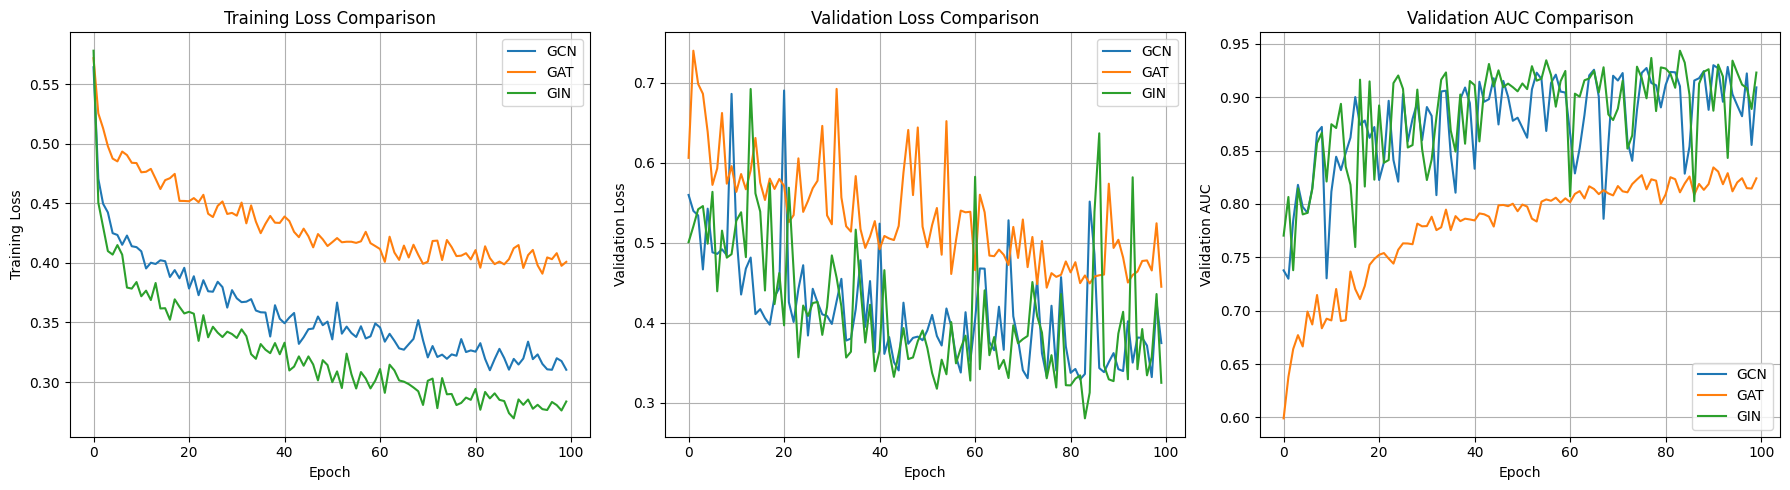

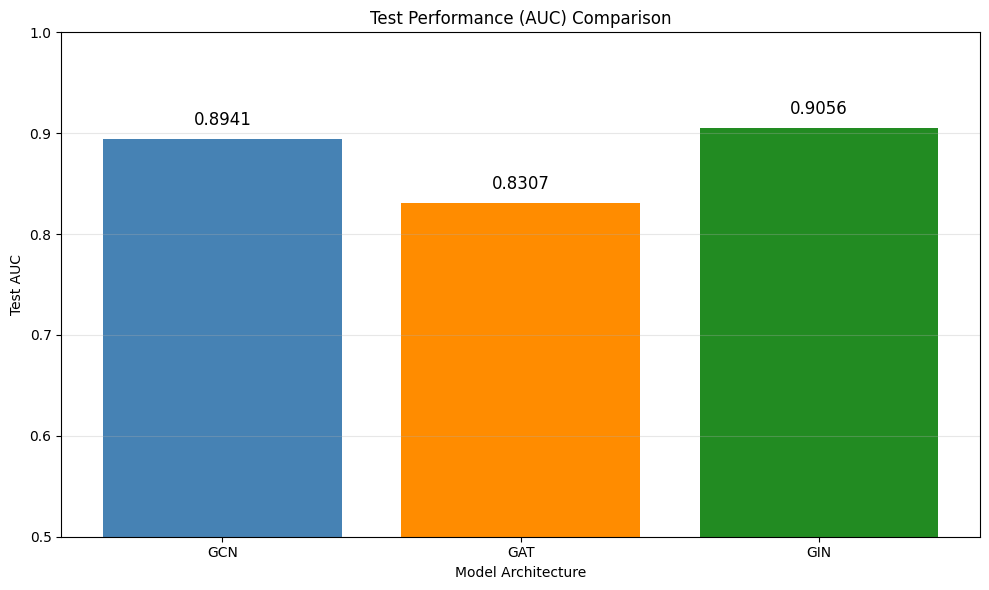

In [ ]:
# Load a dataset from MoleculeNet (binary classification task)
print("Loading BBBP dataset (Blood-Brain Barrier Penetration)...")
dataset = MoleculeNet(root='data', name='BBBP')
print(f"Dataset loaded: {len(dataset)} molecules")

# Split the dataset
torch.manual_seed(42)
indices = torch.randperm(len(dataset))
train_idx = indices[:int(0.8 * len(dataset))]
val_idx = indices[int(0.8 * len(dataset)):int(0.9 * len(dataset))]
test_idx = indices[int(0.9 * len(dataset)):]

train_dataset = dataset[train_idx]
val_dataset = dataset[val_idx]
test_dataset = dataset[test_idx]

print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

# Create data loaders
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# For comparison, let's implement GCN and GAT models as well
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3, dropout=0.5):
        super(GCN, self).__init__()

        self.num_layers = num_layers
        self.dropout = dropout

        # Initial projection of node features
        self.node_encoder = nn.Linear(in_channels, hidden_channels)

        # GCN convolution layers
        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))

        # Batch normalization layers
        self.batch_norms = nn.ModuleList([nn.BatchNorm1d(hidden_channels) for _ in range(num_layers)])

        # Prediction MLP
        self.mlp = MLP(hidden_channels, hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # Initial embedding
        x = self.node_encoder(x.float())

        # GCN layers
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = self.batch_norms[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        # Global pooling (mean)
        x = global_mean_pool(x, batch)

        # Final prediction
        x = self.mlp(x)

        return x

    def get_embeddings(self, x, edge_index, batch):
        """Get node embeddings from the GCN model"""
        # Initial embedding
        x = self.node_encoder(x.float())

        # Store representations from each layer
        xs = []

        # GCN layers (without dropout for inference)
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = self.batch_norms[i](x)
            x = F.relu(x)
            xs.append(x)

        return xs  # Return embeddings from all layers

class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3, heads=4, dropout=0.5):
        super(GAT, self).__init__()

        self.num_layers = num_layers
        self.dropout = dropout

        # Initial projection of node features
        self.node_encoder = nn.Linear(in_channels, hidden_channels)

        # GAT convolution layers
        self.convs = nn.ModuleList()
        for i in range(num_layers):
            # Last layer has 1 head, others have 'heads' number of heads
            heads_in_layer = 1 if i == num_layers - 1 else heads
            heads_out_channels = hidden_channels // heads if i < num_layers - 1 else hidden_channels
            self.convs.append(GATConv(hidden_channels, heads_out_channels, heads=heads_in_layer, dropout=dropout))

        # Batch normalization layers
        self.batch_norms = nn.ModuleList([nn.BatchNorm1d(hidden_channels) for _ in range(num_layers)])

        # Prediction MLP
        self.mlp = MLP(hidden_channels, hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # Initial embedding
        x = self.node_encoder(x.float())

        # GAT layers
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = self.batch_norms[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        # Global pooling (mean)
        x = global_mean_pool(x, batch)

        # Final prediction
        x = self.mlp(x)

        return x

    def get_embeddings(self, x, edge_index, batch):
        """Get node embeddings from the GAT model"""
        # Initial embedding
        x = self.node_encoder(x.float())

        # Store representations from each layer
        xs = []

        # GAT layers (without dropout for inference)
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = self.batch_norms[i](x)
            x = F.relu(x)
            xs.append(x)

        return xs  # Return embeddings from all layers

# Train and evaluate model function
def train_and_evaluate(model, optimizer, train_loader, val_loader, test_loader, device, epochs=100):
    """Train and evaluate a model for molecular property prediction"""
    train_losses = []
    val_losses = []
    val_aucs = []
    best_val_auc = 0
    best_model = None

    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(1, epochs + 1):
        # Training
        model.train()
        total_loss = 0
        total_samples = 0

        for data in train_loader:
            optimizer.zero_grad()
            data = data.to(device)

            out = model(data.x.float(), data.edge_index, data.batch)

            # Ensure output and target have the same batch size
            if out.size(0) != data.y.size(0):
                # If sizes don't match, use the minimum size
                min_size = min(out.size(0), data.y.size(0))
                out = out[:min_size]
                data.y = data.y[:min_size]

            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * data.num_graphs
            total_samples += data.num_graphs

        avg_loss = total_loss / total_samples
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        val_loss = 0
        val_samples = 0
        y_true = []
        y_pred = []

        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                out = model(data.x.float(), data.edge_index, data.batch)

                # Ensure output and target have the same batch size
                if out.size(0) != data.y.size(0):
                    min_size = min(out.size(0), data.y.size(0))
                    out = out[:min_size]
                    data.y = data.y[:min_size]

                loss = criterion(out, data.y)
                val_loss += loss.item() * data.num_graphs
                val_samples += data.num_graphs

                y_true.append(data.y.cpu().numpy())
                y_pred.append(torch.sigmoid(out).cpu().numpy())

        avg_val_loss = val_loss / val_samples
        val_losses.append(avg_val_loss)

        # Calculate validation AUC
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        val_auc = roc_auc_score(y_true, y_pred)
        val_aucs.append(val_auc)

        # Save best model
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model = model.state_dict().copy()

        # Print progress
        if epoch % 10 == 0:
            print(f"Epoch {epoch:03d}: Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val AUC: {val_auc:.4f}")

    # Load best model for evaluation
    model.load_state_dict(best_model)

    # Test evaluation
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data.x.float(), data.edge_index, data.batch)

            # Ensure output and target have the same batch size
            if out.size(0) != data.y.size(0):
                min_size = min(out.size(0), data.y.size(0))
                out = out[:min_size]
                data.y = data.y[:min_size]

            y_true.append(data.y.cpu().numpy())
            y_pred.append(torch.sigmoid(out).cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    test_auc = roc_auc_score(y_true, y_pred)

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_aucs': val_aucs,
        'best_val_auc': best_val_auc,
        'test_auc': test_auc,
        'y_true': y_true,
        'y_pred': y_pred
    }

# Compare GCN, GAT, and GIN
import copy

def compare_gnn_architectures():
    """Train and compare different GNN architectures"""
    # Get input dimension
    sample = dataset[0]
    in_channels = sample.x.shape[1]

    # Define hyperparameters
    hidden_channels = 64
    out_channels = 1  # Binary classification
    num_layers = 3
    dropout = 0.5
    lr = 0.001
    weight_decay = 1e-4
    epochs = 100

    # Initialize models
    models = {
        'GCN': GCN(in_channels, hidden_channels, out_channels, num_layers, dropout).to(device),
        'GAT': GAT(in_channels, hidden_channels, out_channels, num_layers, heads=4, dropout=dropout).to(device),
        'GIN': GIN(in_channels, hidden_channels, out_channels, num_layers, dropout=dropout, epsilon=0).to(device)
    }

    # Train and evaluate models
    results = {}

    for name, model in models.items():
        print(f"\nTraining {name} model...")
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        results[name] = train_and_evaluate(model, optimizer, train_loader, val_loader, test_loader, device, epochs)
        print(f"{name} Test AUC: {results[name]['test_auc']:.4f}")

    return results, models

# Run comparison
results, models = compare_gnn_architectures()

# Visualize training curves
plt.figure(figsize=(18, 5))

# Plot training loss
plt.subplot(1, 3, 1)
for name, result in results.items():
    plt.plot(result['train_losses'], label=name)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)

# Plot validation loss
plt.subplot(1, 3, 2)
for name, result in results.items():
    plt.plot(result['val_losses'], label=name)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.grid(True)

# Plot validation AUC
plt.subplot(1, 3, 3)
for name, result in results.items():
    plt.plot(result['val_aucs'], label=name)
plt.xlabel('Epoch')
plt.ylabel('Validation AUC')
plt.title('Validation AUC Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot test AUC comparison
plt.figure(figsize=(10, 6))
names = list(results.keys())
aucs = [result['test_auc'] for result in results.values()]

bars = plt.bar(names, aucs, color=['steelblue', 'darkorange', 'forestgreen'])
plt.xlabel('Model Architecture')
plt.ylabel('Test AUC')
plt.title('Test Performance (AUC) Comparison')
plt.ylim(0.5, 1.0)  # AUC ranges from 0.5 to 1.0

# Add value labels
for bar, auc in zip(bars, aucs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{auc:.4f}',
            ha='center', va='bottom', fontsize=12)

plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 7. GIN for Molecular Fingerprinting <a name="gin-for-molecular-fingerprinting"></a>

One of the key strengths of GIN is its ability to generate effective molecular fingerprints - numerical representations of molecules that capture their structural features. Let's explore this application:

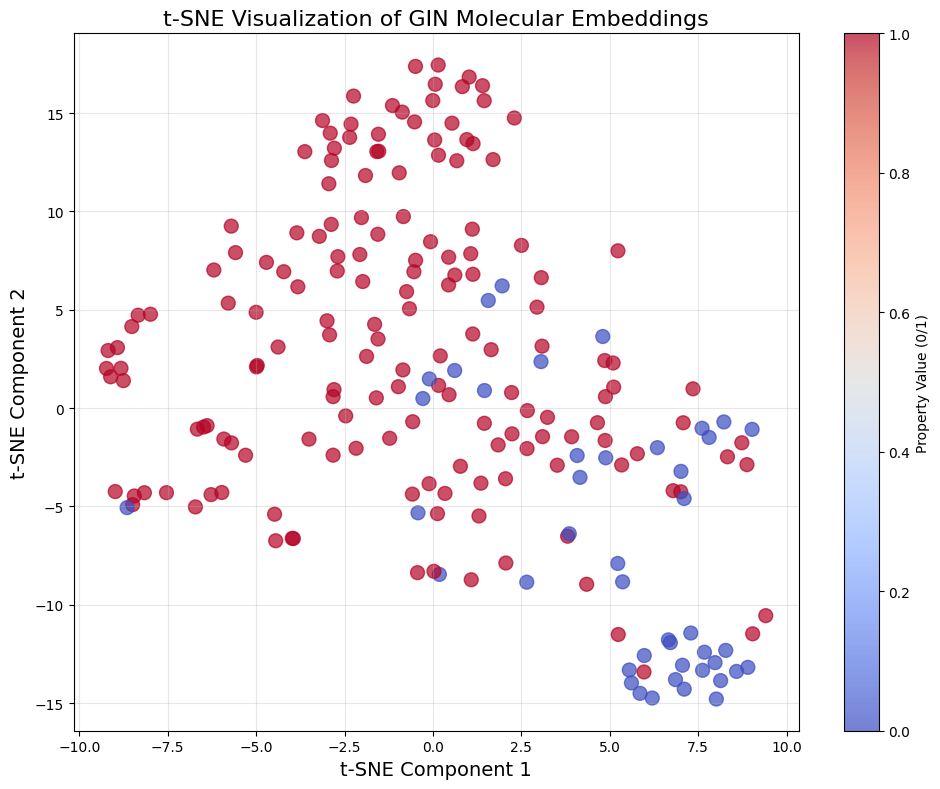

/tmp/ipykernel_477057/1300542290.py:79: RuntimeWarning: invalid value encountered in divide
  embeddings = embeddings / norms


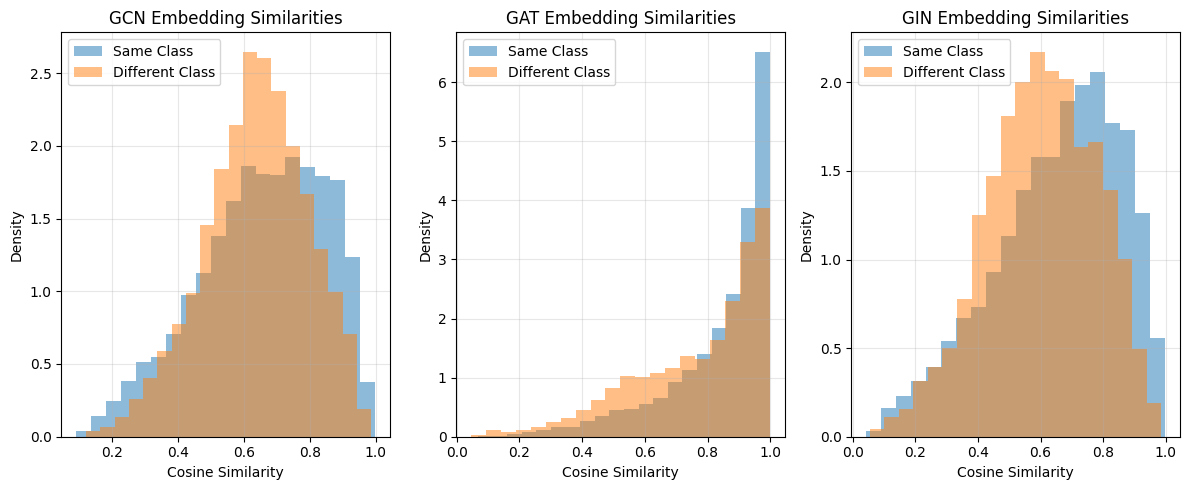

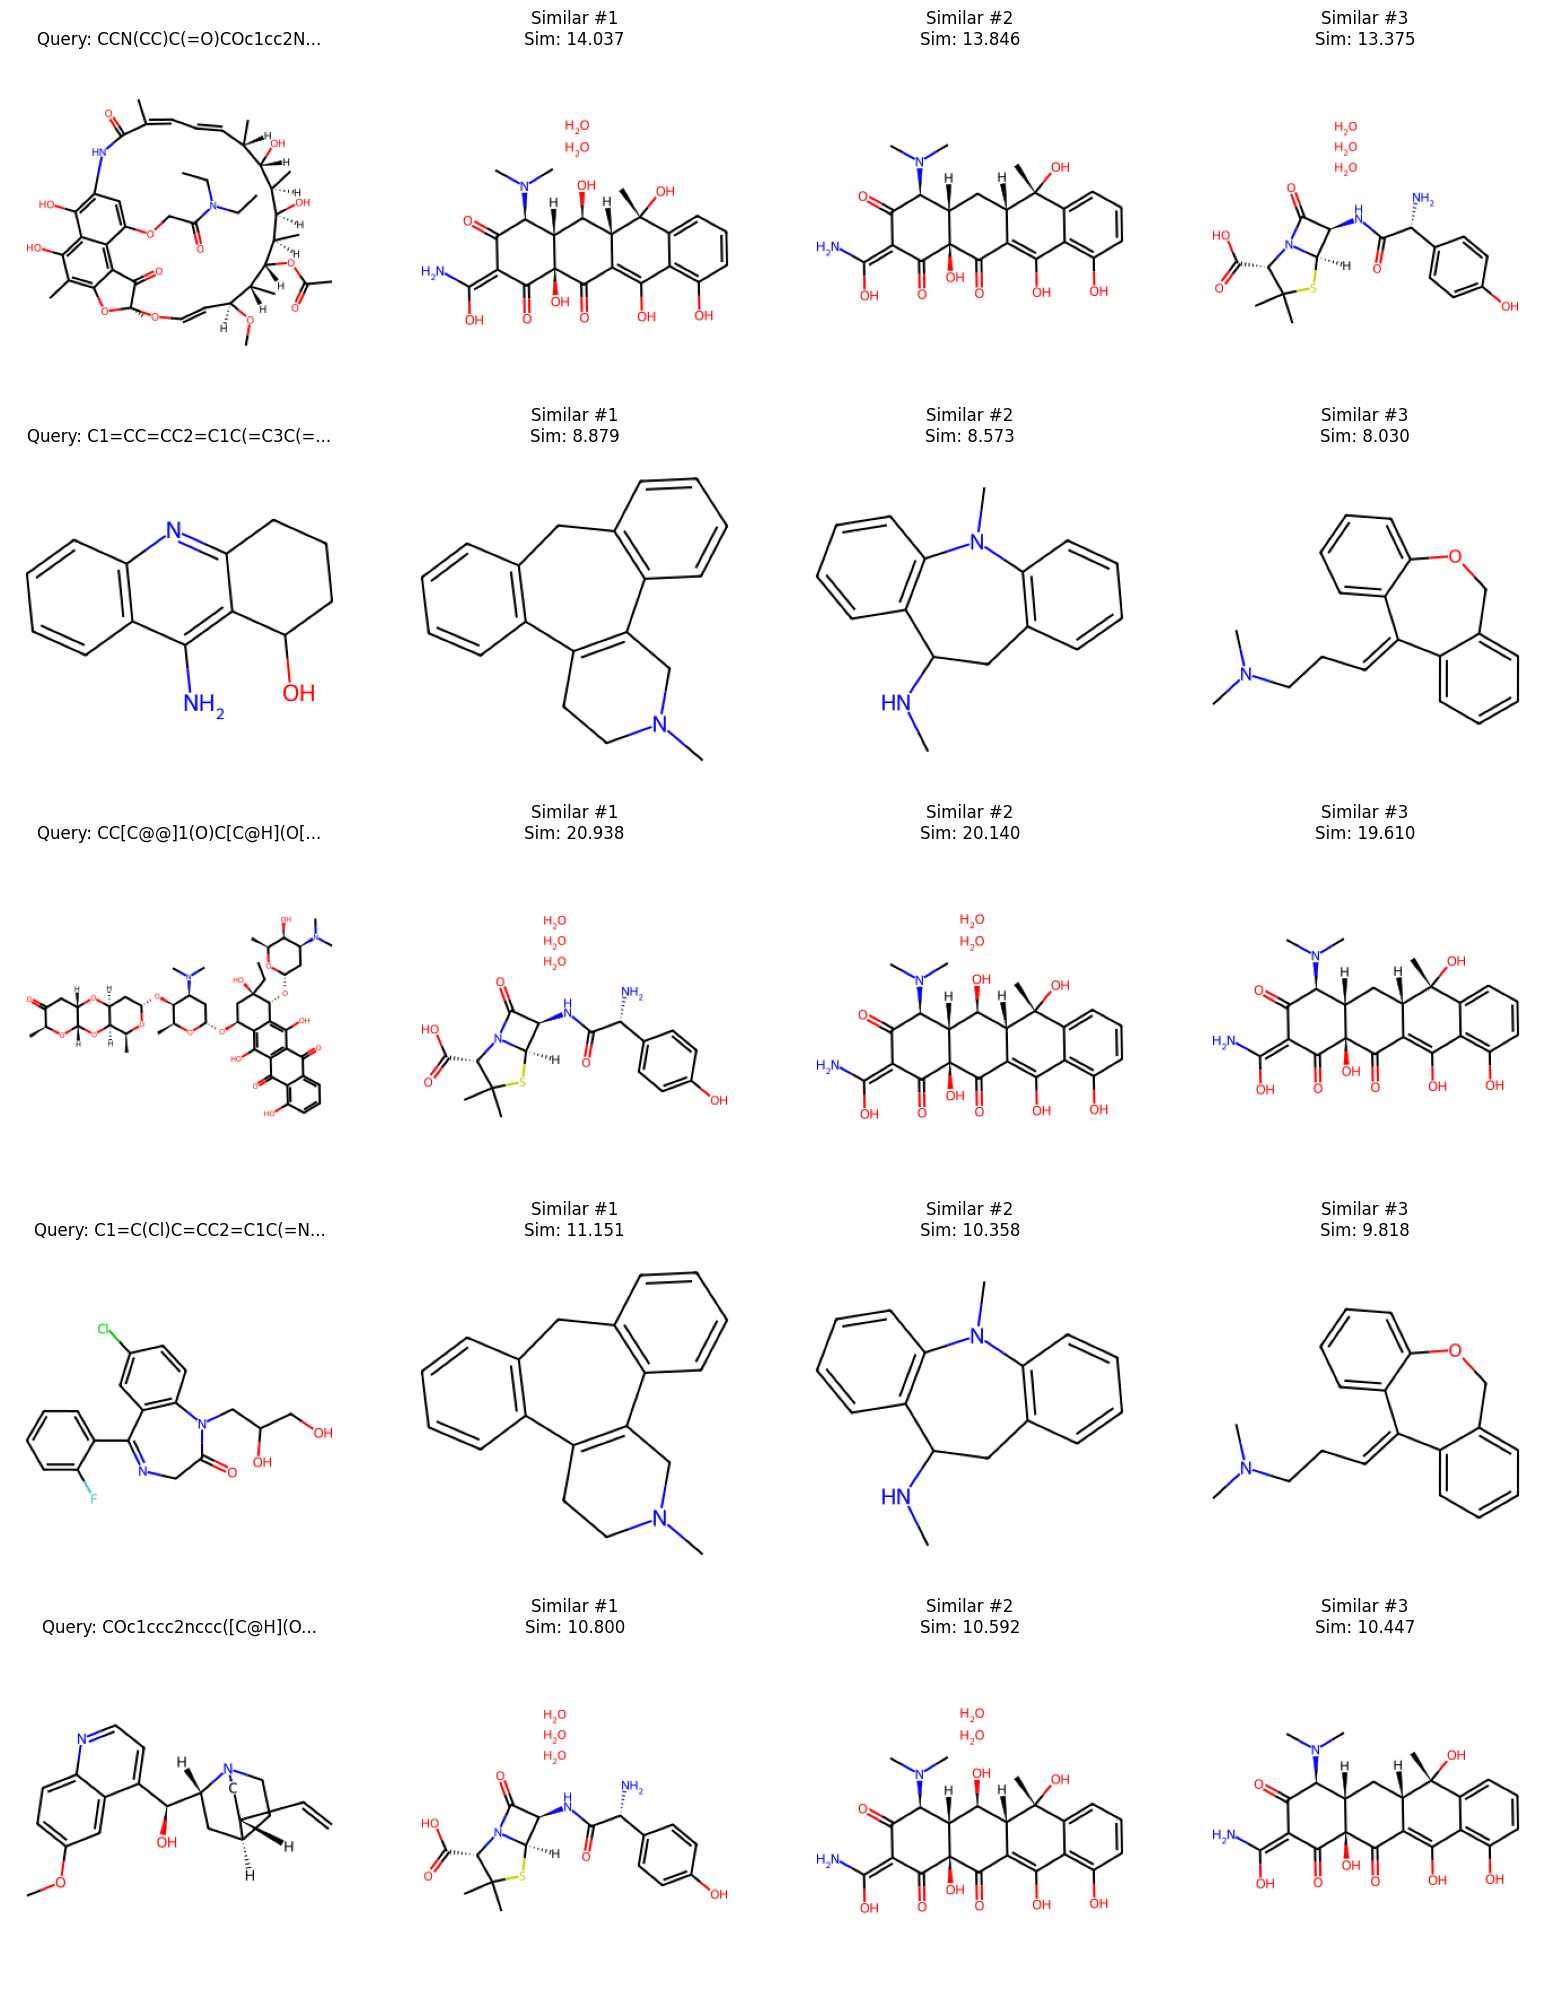

In [ ]:
def generate_molecule_embeddings(model, dataset, device, batch_size=32):
    """Generate molecular embeddings using the trained GIN model"""
    model.eval()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    embeddings = []
    labels = []
    smiles_list = []

    with torch.no_grad():
        for data in loader:
            try:
                data = data.to(device)
                node_embeddings = model.get_embeddings(data.x.float(), data.edge_index, data.batch)
                last_layer_embedding = global_mean_pool(node_embeddings[-1], data.batch)

                embeddings.append(last_layer_embedding.cpu().numpy())
                labels.append(data.y.cpu().numpy())

                if hasattr(data, 'smiles'):
                    smiles_list.extend(data.smiles)

                del data
                torch.cuda.empty_cache()  # If using CUDA
            except Exception as e:
                print(f"Error processing batch: {str(e)}")
                continue

    if not embeddings:
        raise ValueError("No embeddings were generated")

    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)

    return embeddings, labels, smiles_list

# Generate embeddings using the trained GIN model
gin_model = models['GIN']
gin_embeddings, gin_labels, _ = generate_molecule_embeddings(gin_model, test_dataset, device)

# Visualize the embeddings using t-SNE
def visualize_molecular_embeddings(embeddings, labels):
    """Visualize molecular embeddings using t-SNE"""
    # Reduce embedding dimensionality for visualization
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings)-1))
    embeddings_2d = tsne.fit_transform(embeddings)

    # Create scatter plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                        c=labels.squeeze(), cmap='coolwarm', alpha=0.7, s=100)

    plt.colorbar(scatter, label='Property Value (0/1)')
    plt.title('t-SNE Visualization of GIN Molecular Embeddings', fontsize=16)
    plt.xlabel('t-SNE Component 1', fontsize=14)
    plt.ylabel('t-SNE Component 2', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Visualize the GIN embeddings
visualize_molecular_embeddings(gin_embeddings, gin_labels)

# Compare with embeddings from other models
gcn_model = models['GCN']
gat_model = models['GAT']

gcn_embeddings, gcn_labels, _ = generate_molecule_embeddings(gcn_model, test_dataset, device)
gat_embeddings, gat_labels, _ = generate_molecule_embeddings(gat_model, test_dataset, device)


# Calculate embedding similarity
def calculate_similarity_matrix(embeddings, normalize=True):
    """Calculate cosine similarity matrix between embeddings"""
    # Normalize if requested
    if normalize:
        norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
        embeddings = embeddings / norms

    # Calculate cosine similarity
    similarity_matrix = np.dot(embeddings, embeddings.T)
    return similarity_matrix

# Compare similarity distributions
plt.figure(figsize=(12, 5))

# Process each model's embeddings
models_data = [
    ('GCN', gcn_embeddings),
    ('GAT', gat_embeddings),
    ('GIN', gin_embeddings)
]

for i, (name, embeddings) in enumerate(models_data):
    plt.subplot(1, 3, i+1)

    # Split by class
    class_0_idx = np.where(gin_labels.squeeze() < 0.5)[0]
    class_1_idx = np.where(gin_labels.squeeze() >= 0.5)[0]

    # Calculate similarity matrices
    sim_matrix = calculate_similarity_matrix(embeddings)

    # Extract similarities between same class and different class
    same_class_sim = []
    diff_class_sim = []

    for j in range(len(embeddings)):
        for k in range(j+1, len(embeddings)):
            if (j in class_0_idx and k in class_0_idx) or (j in class_1_idx and k in class_1_idx):
                same_class_sim.append(sim_matrix[j, k])
            else:
                diff_class_sim.append(sim_matrix[j, k])

    # Plot distributions
    plt.hist(same_class_sim, bins=20, alpha=0.5, label='Same Class', density=True)
    plt.hist(diff_class_sim, bins=20, alpha=0.5, label='Different Class', density=True)

    plt.xlabel('Cosine Similarity')
    plt.ylabel('Density')
    plt.title(f'{name} Embedding Similarities')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


def visualize_molecular_similarity(test_dataset, model, device, num_molecules=5, top_k=3):
    """Visualize molecular similarities based on GIN embeddings"""
    model.eval()

    try:
        subset_indices = np.random.choice(len(test_dataset), num_molecules, replace=False)
        query_molecules = [test_dataset[i] for i in subset_indices]

        all_embeddings, _, all_smiles = generate_molecule_embeddings(model, test_dataset, device)

        fig, axes = plt.subplots(num_molecules, top_k + 1, figsize=(4 * (top_k + 1), 4 * num_molecules))

        for i, query_mol in enumerate(query_molecules):
            try:
                query_data = query_mol.to(device)
                with torch.no_grad():
                    # Remove the unsqueeze operations that were adding extra dimensions
                    node_embeddings = model.get_embeddings(
                        query_data.x.float(),  # No need for unsqueeze
                        query_data.edge_index,  # No need for unsqueeze
                        torch.zeros(query_data.x.size(0), dtype=torch.long, device=device)
                    )
                    query_embedding = global_mean_pool(
                        node_embeddings[-1],
                        torch.zeros(query_data.x.size(0), dtype=torch.long, device=device)
                    )
                    query_embedding = query_embedding.cpu().numpy()

                similarities = np.dot(all_embeddings, query_embedding.T).squeeze()
                sorted_indices = np.argsort(similarities)[::-1]

                if hasattr(query_mol, 'smiles'):
                    query_idx = all_smiles.index(query_mol.smiles) if query_mol.smiles in all_smiles else -1
                    if query_idx >= 0 and query_idx in sorted_indices:
                        sorted_indices = np.delete(sorted_indices, np.where(sorted_indices == query_idx))

                top_k_indices = sorted_indices[:top_k]

                if hasattr(query_mol, 'smiles'):
                    try:
                        mol = Chem.MolFromSmiles(query_mol.smiles)
                        if mol is not None:
                            drawer = rdMolDraw2D.MolDraw2DCairo(300, 300)
                            drawer.DrawMolecule(mol)
                            drawer.FinishDrawing()
                            img = drawer.GetDrawingText()
                            query_img = Image.open(io.BytesIO(img))
                            axes[i, 0].imshow(query_img)
                            axes[i, 0].set_title(f"Query: {query_mol.smiles[:20]}...")
                            axes[i, 0].axis('off')

                            for j, idx in enumerate(top_k_indices):
                                if idx < len(test_dataset) and hasattr(test_dataset[idx], 'smiles'):
                                    similar_smiles = test_dataset[idx].smiles
                                    similar_mol = Chem.MolFromSmiles(similar_smiles)
                                    if similar_mol:
                                        drawer = rdMolDraw2D.MolDraw2DCairo(300, 300)
                                        drawer.DrawMolecule(similar_mol)
                                        drawer.FinishDrawing()
                                        img = drawer.GetDrawingText()
                                        similar_img = Image.open(io.BytesIO(img))
                                        axes[i, j+1].imshow(similar_img)
                                        axes[i, j+1].set_title(f"Similar #{j+1}\nSim: {similarities[idx]:.3f}")
                                        axes[i, j+1].axis('off')
                    except Exception as e:
                        print(f"Error processing molecule {i}: {str(e)}")
                        continue

            except Exception as e:
                print(f"Error processing query molecule {i}: {str(e)}")
                continue

        plt.tight_layout()
        plt.show()
        plt.close()
    except Exception as e:
        print(f"Error in visualization: {str(e)}")

# Visualize molecular similarities for the GIN model
visualize_molecular_similarity(test_dataset, models["GIN"], device)

## 8. Analyzing Isomorphic vs. Non-Isomorphic Molecule Pairs <a name="analyzing-isomorphic-vs-non-isomorphic-molecule-pairs"></a>

Let's demonstrate the discriminative power of GIN on isomorphic and non-isomorphic molecule pairs:

/tmp/ipykernel_477057/2689209174.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'similarity': float(similarity)
/tmp/ipykernel_477057/2689209174.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'similarity': float(similarity)


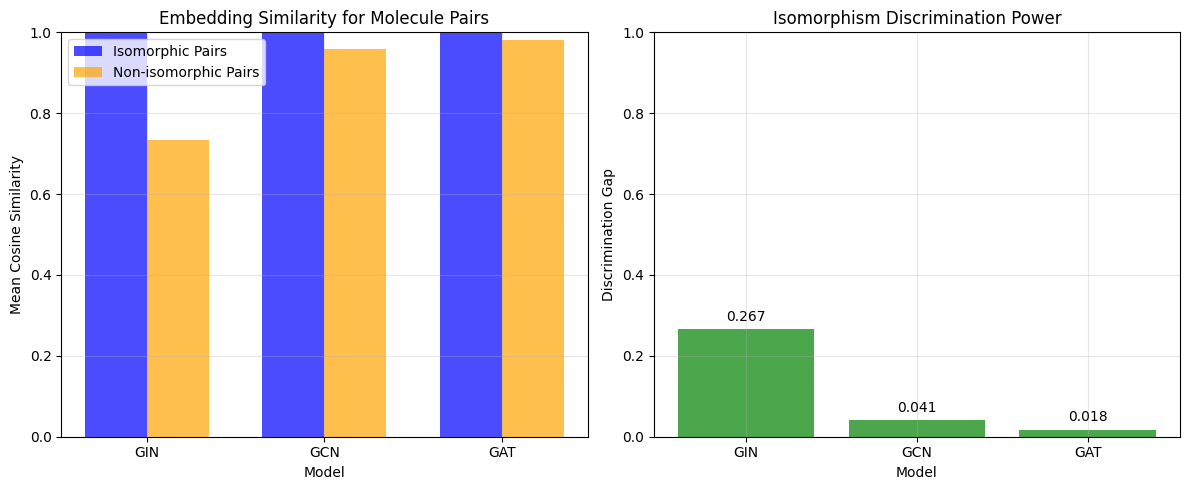

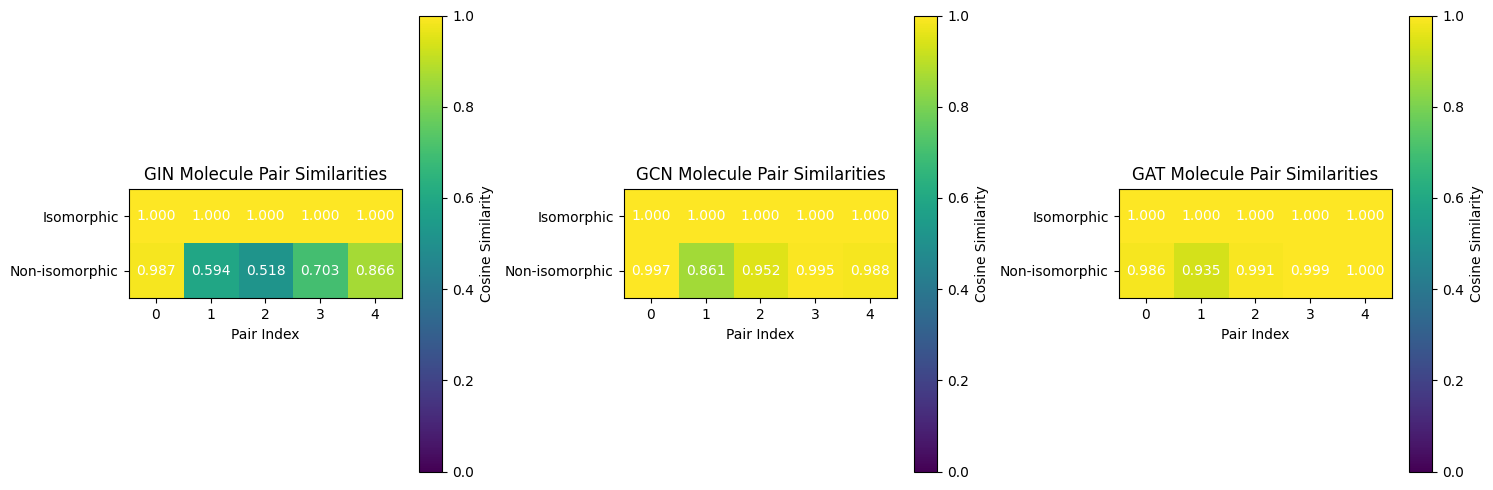

In [ ]:
def analyze_isomorphism_discrimination(model, device):
    """Analyze how well the model distinguishes between isomorphic and non-isomorphic molecules"""
    # Isomorphic SMILES pairs (same molecule, different representations)
    isomorphic_pairs = [
        # Ethanol representations
        ("CCO", "OCC"),
        # Toluene representations
        ("Cc1ccccc1", "C1=CC=C(C)C=C1"),
        # Benzene representations
        ("c1ccccc1", "C1=CC=CC=C1"),
        # Acetone representations
        ("CC(=O)C", "CC(C)=O"),
        # Methoxymethane representations
        ("COC", "O(C)C")
    ]

    # Non-isomorphic but similar SMILES pairs
    non_isomorphic_pairs = [
        # Ethanol vs. Dimethyl ether (same formula, different structure)
        ("CCO", "COC"),
        # Propane vs. Cyclopropane
        ("CCC", "C1CC1"),
        # Benzene vs. Cyclohexane
        ("c1ccccc1", "C1CCCCC1"),
        # Acetone vs. Propanal
        ("CC(=O)C", "CCC=O"),
        # Butane vs. Isobutane
        ("CCCC", "CC(C)C")
    ]

    model.eval()

    results = {
        'isomorphic': [],
        'non_isomorphic': []
    }

    def get_embedding(smiles):
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        data = mol_to_graph(smiles)
        data = data.to(device)

        with torch.no_grad():
            node_embeddings = model.get_embeddings(data.x, data.edge_index, torch.zeros(data.x.size(0), dtype=torch.long, device=device))
            graph_embedding = global_mean_pool(node_embeddings[-1], torch.zeros(data.x.size(0), dtype=torch.long, device=device))

        return graph_embedding.cpu().numpy()

    # Process isomorphic pairs
    for smiles1, smiles2 in isomorphic_pairs:
        emb1 = get_embedding(smiles1)
        emb2 = get_embedding(smiles2)

        if emb1 is not None and emb2 is not None:
            # Calculate cosine similarity
            similarity = np.dot(emb1, emb2.T) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
            results['isomorphic'].append({
                'smiles1': smiles1,
                'smiles2': smiles2,
                'similarity': float(similarity)
            })

    # Process non-isomorphic pairs
    for smiles1, smiles2 in non_isomorphic_pairs:
        emb1 = get_embedding(smiles1)
        emb2 = get_embedding(smiles2)

        if emb1 is not None and emb2 is not None:
            # Calculate cosine similarity
            similarity = np.dot(emb1, emb2.T) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
            results['non_isomorphic'].append({
                'smiles1': smiles1,
                'smiles2': smiles2,
                'similarity': float(similarity)
            })

    return results

# Analyze discrimination for all models
gin_results = analyze_isomorphism_discrimination(gin_model, device)
gcn_results = analyze_isomorphism_discrimination(gcn_model, device)
gat_results = analyze_isomorphism_discrimination(gat_model, device)

# Function to visualize the results
def visualize_isomorphism_results(gin_results, gcn_results, gat_results):
    """Visualize the isomorphism test results for different models"""
    models = ['GIN', 'GCN', 'GAT']
    iso_similarities = [
        [r['similarity'] for r in gin_results['isomorphic']],
        [r['similarity'] for r in gcn_results['isomorphic']],
        [r['similarity'] for r in gat_results['isomorphic']]
    ]

    non_iso_similarities = [
        [r['similarity'] for r in gin_results['non_isomorphic']],
        [r['similarity'] for r in gcn_results['non_isomorphic']],
        [r['similarity'] for r in gat_results['non_isomorphic']]
    ]

    # Calculate mean similarities
    iso_means = [np.mean(sims) for sims in iso_similarities]
    non_iso_means = [np.mean(sims) for sims in non_iso_similarities]

    # Calculate the discrimination gap (difference between isomorphic and non-isomorphic similarities)
    discrimination_gaps = [iso - non for iso, non in zip(iso_means, non_iso_means)]

    # Plot mean similarities
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    x = np.arange(len(models))
    width = 0.35

    plt.bar(x - width/2, iso_means, width, label='Isomorphic Pairs', color='blue', alpha=0.7)
    plt.bar(x + width/2, non_iso_means, width, label='Non-isomorphic Pairs', color='orange', alpha=0.7)

    plt.xlabel('Model')
    plt.ylabel('Mean Cosine Similarity')
    plt.title('Embedding Similarity for Molecule Pairs')
    plt.xticks(x, models)
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot discrimination gap
    plt.subplot(1, 2, 2)
    plt.bar(models, discrimination_gaps, color='green', alpha=0.7)
    plt.xlabel('Model')
    plt.ylabel('Discrimination Gap')
    plt.title('Isomorphism Discrimination Power')
    plt.ylim(0, 1.0)

    # Add value labels
    for i, v in enumerate(discrimination_gaps):
        plt.text(i, v + 0.02, f'{v:.3f}', ha='center')

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot detailed similarity matrix for specific pairs
    plt.figure(figsize=(15, 5))

    for i, model_name in enumerate(models):
        plt.subplot(1, 3, i+1)

        # Combine results
        all_results = []
        model_results = [gin_results, gcn_results, gat_results][i]

        for j, pair in enumerate(model_results['isomorphic']):
            all_results.append({
                'x': j,
                'y': 0,
                'similarity': pair['similarity'],
                'smiles1': pair['smiles1'],
                'smiles2': pair['smiles2'],
                'type': 'Isomorphic'
            })

        for j, pair in enumerate(model_results['non_isomorphic']):
            all_results.append({
                'x': j,
                'y': 1,
                'similarity': pair['similarity'],
                'smiles1': pair['smiles1'],
                'smiles2': pair['smiles2'],
                'type': 'Non-isomorphic'
            })

        # Create similarity matrix
        matrix = np.zeros((2, 5))
        for r in all_results:
            matrix[r['y'], r['x']] = r['similarity']

        # Plot matrix
        im = plt.imshow(matrix, cmap='viridis', vmin=0, vmax=1)
        plt.colorbar(im, label='Cosine Similarity')

        plt.title(f"{model_name} Molecule Pair Similarities")
        plt.xlabel('Pair Index')
        plt.yticks([0, 1], ['Isomorphic', 'Non-isomorphic'])

        # Add similarity values
        for r in all_results:
            plt.text(r['x'], r['y'], f"{r['similarity']:.3f}", ha='center', va='center',
                   color='white' if r['similarity'] > 0.5 else 'black')

    plt.tight_layout()
    plt.show()

# Visualize the results
visualize_isomorphism_results(gin_results, gcn_results, gat_results)

## 9. Interpreting GIN Embeddings for Chemical Insights <a name="interpreting-gin-embeddings-for-chemical-insights"></a>

Let's analyze what chemical information GIN embeddings are capturing:

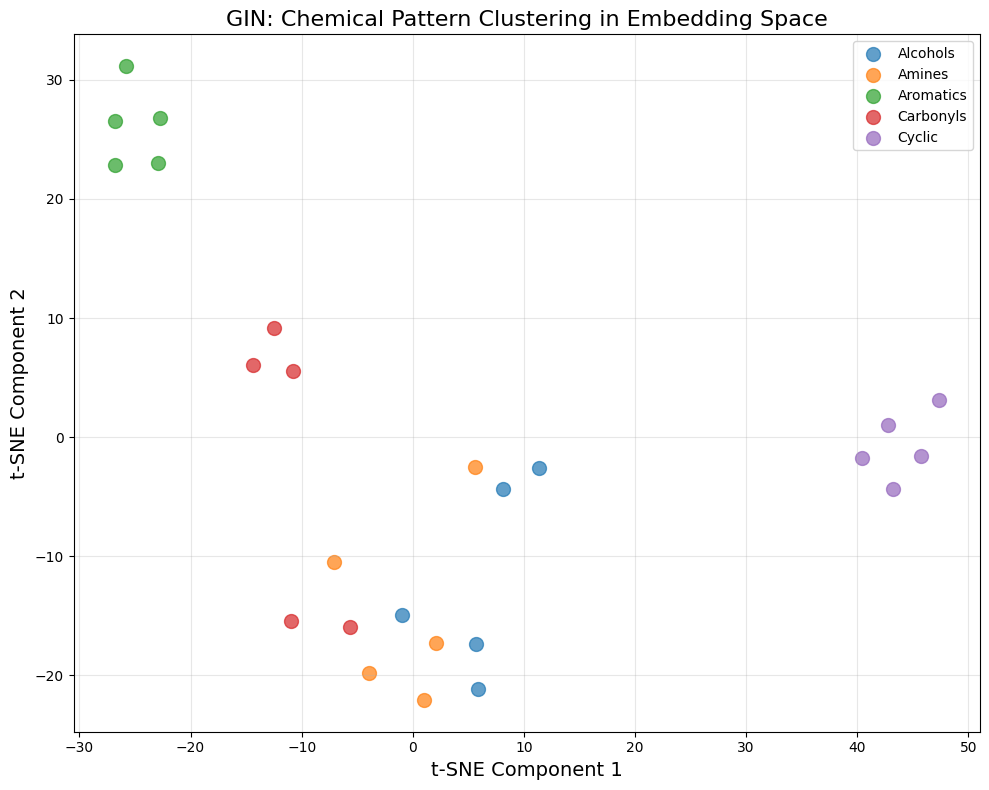

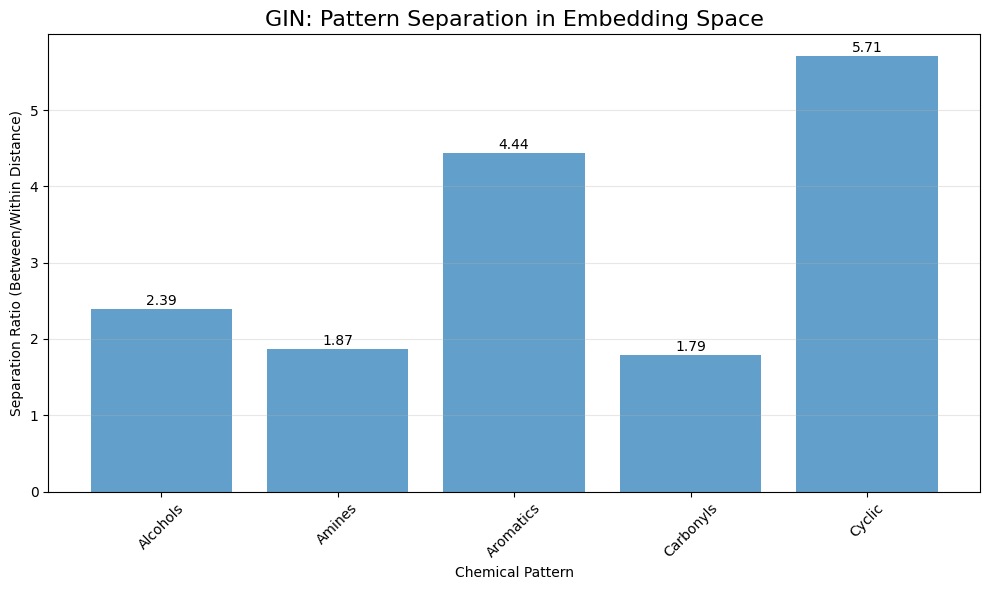

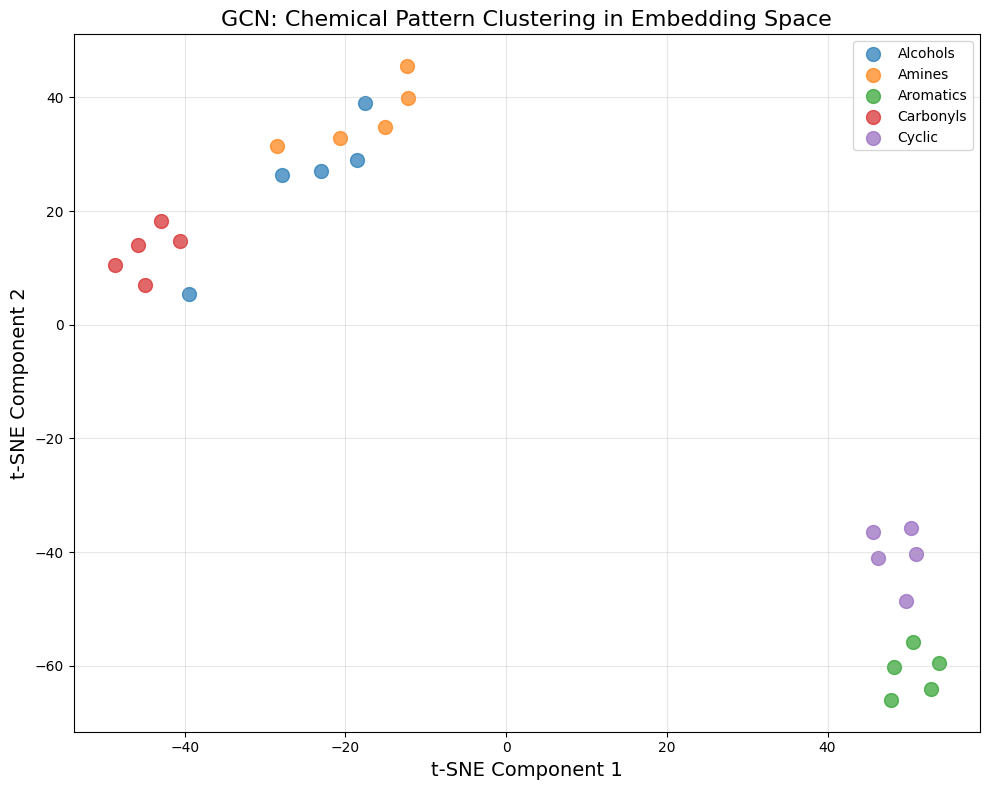

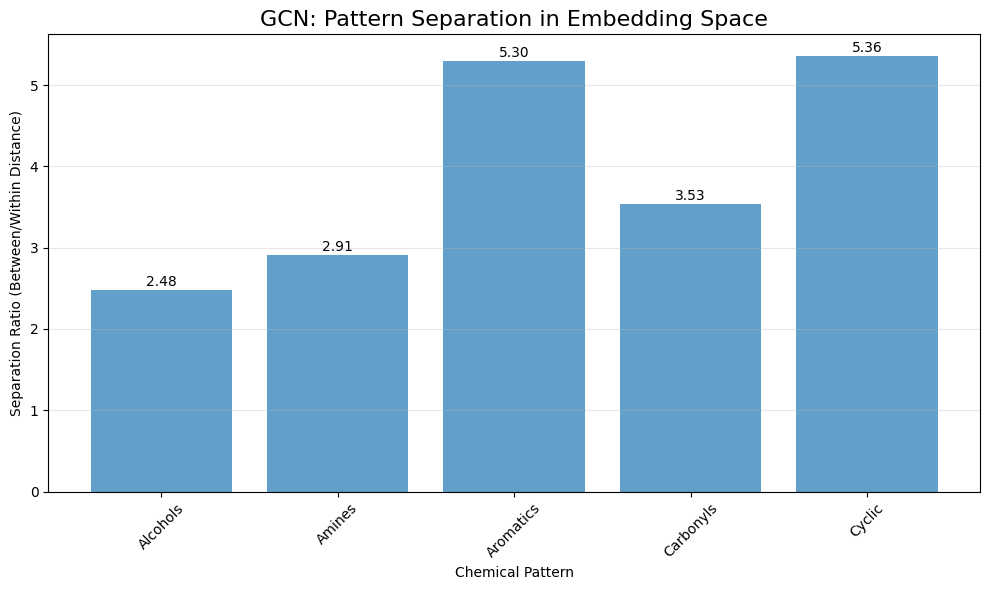

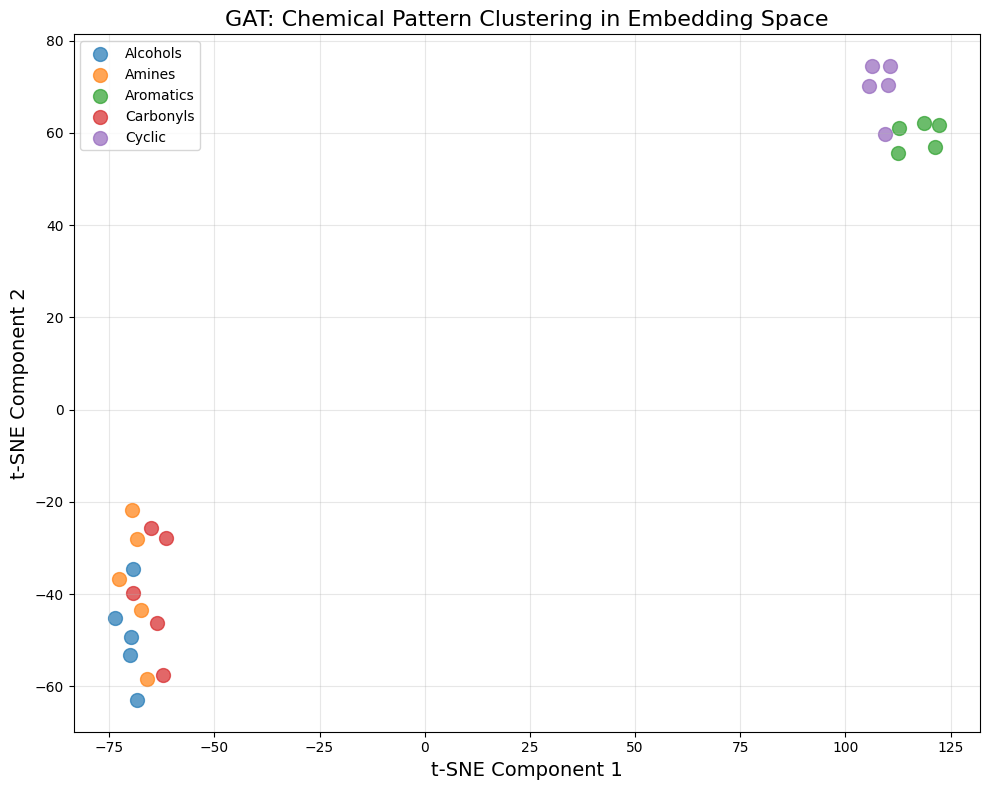

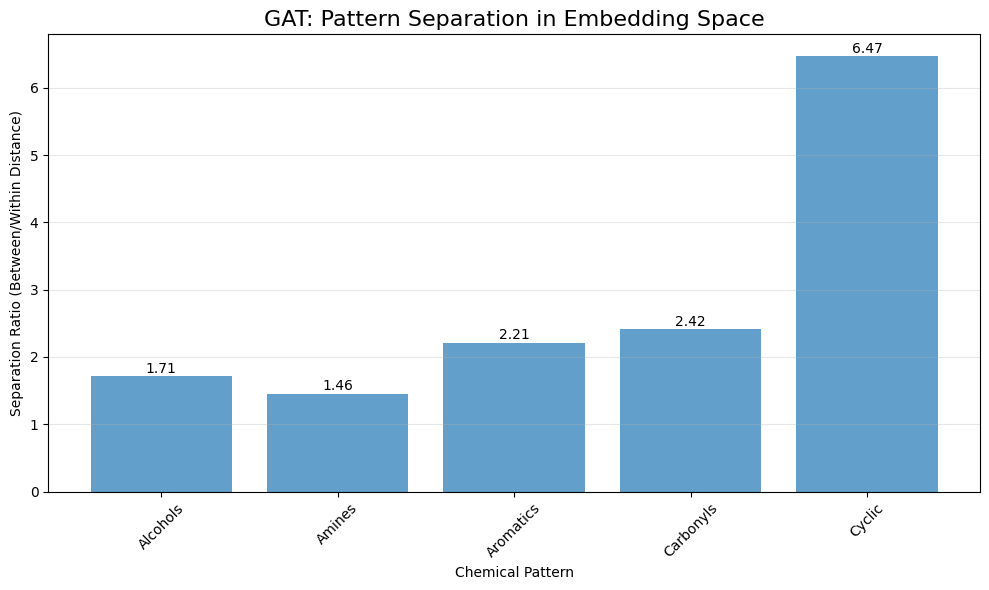

In [ ]:
def analyze_chemical_patterns(model, device):
    """Analyze how GIN embeddings capture chemical patterns"""
    # Define molecule sets with specific patterns
    pattern_sets = {
        'Alcohols': ['CCO', 'CCCO', 'CCCCO', 'CC(C)O', 'OCC(O)CO'],
        'Amines': ['CN', 'CCN', 'CCCN', 'CC(C)N', 'NCCN'],
        'Aromatics': ['c1ccccc1', 'c1ccccc1C', 'c1ccccc1O', 'c1ccccc1N', 'c1ccc2ccccc2c1'],
        'Carbonyls': ['CC=O', 'CCC=O', 'CC(=O)C', 'CC(=O)O', 'CC(=O)N'],
        'Cyclic': ['C1CCCCC1', 'C1CCC1', 'C1CCCC1', 'C1CCCCCCC1', 'C1CC2CCC1CC2']
    }

    # Process each set and get embeddings
    embeddings_by_pattern = {}
    smiles_by_pattern = {}

    for pattern, smiles_list in pattern_sets.items():
        embeddings = []
        valid_smiles = []

        for smiles in smiles_list:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                continue

            data = mol_to_graph(smiles)
            data = data.to(device)

            with torch.no_grad():
                node_embeddings = model.get_embeddings(data.x, data.edge_index,
                                                   torch.zeros(data.x.size(0), dtype=torch.long, device=device))
                graph_embedding = global_mean_pool(node_embeddings[-1],
                                               torch.zeros(data.x.size(0), dtype=torch.long, device=device))

            embeddings.append(graph_embedding.cpu().numpy())
            valid_smiles.append(smiles)

        if embeddings:
            embeddings_by_pattern[pattern] = np.vstack(embeddings)
            smiles_by_pattern[pattern] = valid_smiles

    return embeddings_by_pattern, smiles_by_pattern

# Get embeddings by chemical pattern for each model
gin_pattern_embeddings, gin_pattern_smiles = analyze_chemical_patterns(gin_model, device)
gcn_pattern_embeddings, gcn_pattern_smiles = analyze_chemical_patterns(gcn_model, device)
gat_pattern_embeddings, gat_pattern_smiles = analyze_chemical_patterns(gat_model, device)

# Function to visualize the chemical patterns
def visualize_chemical_patterns(model_embeddings, model_smiles, model_name):
    """Visualize how the embeddings cluster by chemical pattern"""
    # Combine all embeddings
    all_embeddings = []
    all_patterns = []

    for pattern, embeddings in model_embeddings.items():
        all_embeddings.append(embeddings)
        all_patterns.extend([pattern] * len(embeddings))

    if all_embeddings:
        all_embeddings = np.vstack(all_embeddings)

        # Map patterns to colors
        pattern_types = list(model_embeddings.keys())
        pattern_to_color = {pattern: i for i, pattern in enumerate(pattern_types)}

        # Reduce dimensionality for visualization
        if len(all_embeddings) > 2:  # Need at least 3 points for t-SNE
            tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(all_embeddings)-1))
            embeddings_2d = tsne.fit_transform(all_embeddings)

            # Create scatter plot
            plt.figure(figsize=(10, 8))

            for pattern in pattern_types:
                pattern_indices = [i for i, p in enumerate(all_patterns) if p == pattern]
                if pattern_indices:
                    plt.scatter(embeddings_2d[pattern_indices, 0], embeddings_2d[pattern_indices, 1],
                               label=pattern, s=100, alpha=0.7)

            plt.title(f'{model_name}: Chemical Pattern Clustering in Embedding Space', fontsize=16)
            plt.xlabel('t-SNE Component 1', fontsize=14)
            plt.ylabel('t-SNE Component 2', fontsize=14)
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

            # Calculate within-pattern and between-pattern distances
            pattern_stats = {}

            for pattern in pattern_types:
                pattern_indices = np.array([i for i, p in enumerate(all_patterns) if p == pattern])
                if len(pattern_indices) >= 2:  # Need at least 2 molecules to calculate within-pattern distances
                    pattern_embeddings = all_embeddings[pattern_indices]

                    # Calculate pairwise distances within the pattern
                    within_distances = []
                    for i in range(len(pattern_embeddings)):
                        for j in range(i + 1, len(pattern_embeddings)):
                            dist = np.linalg.norm(pattern_embeddings[i] - pattern_embeddings[j])
                            within_distances.append(dist)

                    # Calculate distances to other patterns
                    between_distances = []
                    for other_pattern in pattern_types:
                        if other_pattern != pattern:
                            other_indices = np.array([i for i, p in enumerate(all_patterns) if p == other_pattern])
                            if len(other_indices) > 0:
                                other_embeddings = all_embeddings[other_indices]
                                for emb1 in pattern_embeddings:
                                    for emb2 in other_embeddings:
                                        dist = np.linalg.norm(emb1 - emb2)
                                        between_distances.append(dist)

                    pattern_stats[pattern] = {
                        'within_mean': np.mean(within_distances) if within_distances else 0,
                        'between_mean': np.mean(between_distances) if between_distances else 0,
                        'separation_ratio': np.mean(between_distances) / np.mean(within_distances) if within_distances and between_distances else 0
                    }

            # Plot separation statistics
            plt.figure(figsize=(10, 6))
            patterns = list(pattern_stats.keys())
            separation_ratios = [pattern_stats[p]['separation_ratio'] for p in patterns]

            plt.bar(patterns, separation_ratios, alpha=0.7)
            plt.xlabel('Chemical Pattern')
            plt.ylabel('Separation Ratio (Between/Within Distance)')
            plt.title(f'{model_name}: Pattern Separation in Embedding Space', fontsize=16)
            plt.xticks(rotation=45)
            plt.grid(True, axis='y', alpha=0.3)

            # Add value labels
            for i, v in enumerate(separation_ratios):
                plt.text(i, v + 0.05, f'{v:.2f}', ha='center')

            plt.tight_layout()
            plt.show()

# Visualize chemical patterns for each model
visualize_chemical_patterns(gin_pattern_embeddings, gin_pattern_smiles, 'GIN')
visualize_chemical_patterns(gcn_pattern_embeddings, gcn_pattern_smiles, 'GCN')
visualize_chemical_patterns(gat_pattern_embeddings, gat_pattern_smiles, 'GAT')

## 10. Ablation Studies: Understanding GIN Components <a name="ablation-studies-understanding-gin-components"></a>

Let's examine how different components of GIN affect its performance:


Training Full GIN model...
Epoch 010: Train Loss: 0.3909, Val Loss: 0.5239, Val AUC: 0.8780
Epoch 020: Train Loss: 0.3617, Val Loss: 0.8607, Val AUC: 0.8016
Epoch 030: Train Loss: 0.3424, Val Loss: 0.3714, Val AUC: 0.9140
Epoch 040: Train Loss: 0.3304, Val Loss: 0.6406, Val AUC: 0.8789
Epoch 050: Train Loss: 0.3099, Val Loss: 0.3402, Val AUC: 0.9126
Full GIN Test AUC: 0.8951

Training No MLP model...
Epoch 010: Train Loss: 0.4047, Val Loss: 0.6273, Val AUC: 0.7248
Epoch 020: Train Loss: 0.3885, Val Loss: 0.4384, Val AUC: 0.8711
Epoch 030: Train Loss: 0.3668, Val Loss: 0.3802, Val AUC: 0.8951
Epoch 040: Train Loss: 0.3536, Val Loss: 0.3843, Val AUC: 0.9264
Epoch 050: Train Loss: 0.3411, Val Loss: 0.4428, Val AUC: 0.8362
No MLP Test AUC: 0.8385

Training Mean Aggregation model...
Epoch 010: Train Loss: 0.4227, Val Loss: 0.4704, Val AUC: 0.8184
Epoch 020: Train Loss: 0.3952, Val Loss: 0.3895, Val AUC: 0.8774
Epoch 030: Train Loss: 0.3787, Val Loss: 0.5098, Val AUC: 0.8948
Epoch 040: Trai

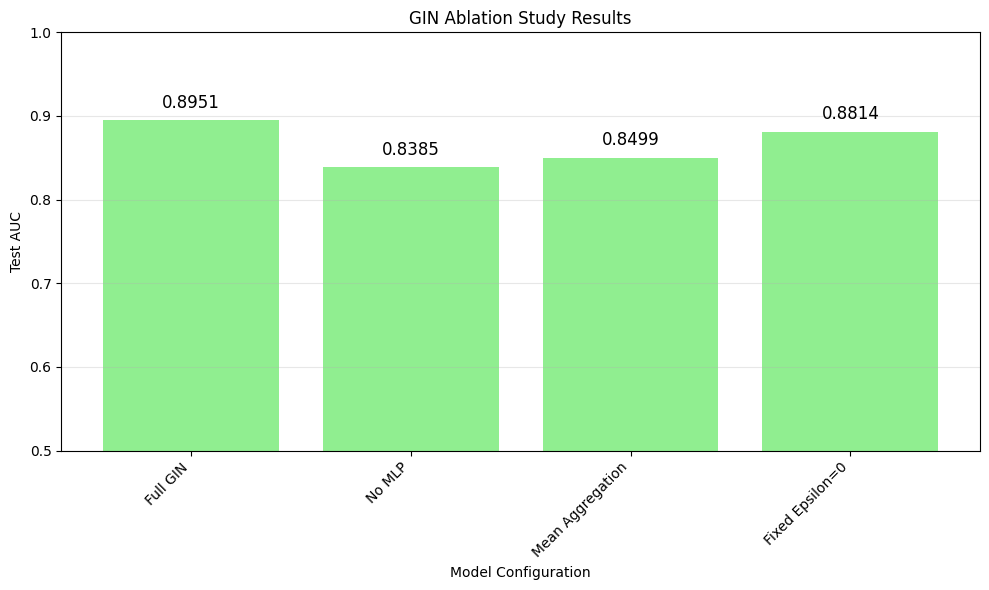

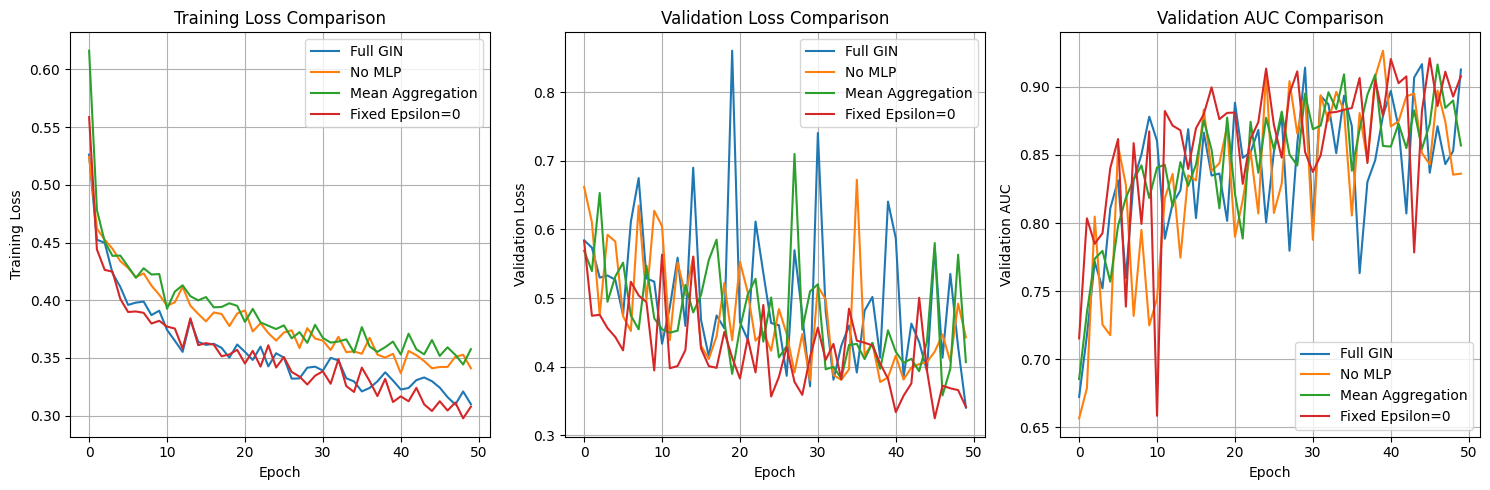

In [ ]:
class GIN_Ablation(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3, dropout=0.5,
                 epsilon=0, use_mlp=True, aggregation='sum'):
        super(GIN_Ablation, self).__init__()

        self.num_layers = num_layers
        self.dropout = dropout
        self.use_mlp = use_mlp
        self.aggregation = aggregation

        # Initial projection of node features
        self.node_encoder = nn.Linear(in_channels, hidden_channels)

        # GIN convolution layers
        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            if use_mlp:
                mlp = MLP(hidden_channels, hidden_channels, hidden_channels)
            else:
                mlp = nn.Linear(hidden_channels, hidden_channels)

            # Choose the appropriate layer based on aggregation method
            if aggregation == 'sum':
                self.convs.append(GINConv(mlp, train_eps=True, eps=epsilon))
            elif aggregation == 'mean':
                # For mean aggregation, we'll use a custom layer
                self.convs.append(GCNConv(hidden_channels, hidden_channels))
            else:
                raise ValueError(f"Unknown aggregation method: {aggregation}")

        # Batch normalization layers
        self.batch_norms = nn.ModuleList([nn.BatchNorm1d(hidden_channels) for _ in range(num_layers)])

        # Prediction MLP
        self.mlp = MLP(hidden_channels, hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # Initial embedding
        x = self.node_encoder(x)

        # Store representations from each layer for readout
        xs = []

        # GIN layers
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = self.batch_norms[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            xs.append(x)

        # Global pooling (mean)
        x = global_mean_pool(x, batch)

        # Final prediction
        x = self.mlp(x)

        return x

def ablation_study():
    """Perform ablation study on GIN components"""
    # Get input dimension
    sample = dataset[0]
    in_channels = sample.x.shape[1]

    # Define hyperparameters
    hidden_channels = 64
    out_channels = 1  # Binary classification
    num_layers = 3
    dropout = 0.5
    lr = 0.001
    weight_decay = 1e-4
    epochs = 50  # Shorter training for ablation

    # Define ablation configurations
    ablation_configs = {
        'Full GIN': {
            'epsilon': 0,
            'use_mlp': True,
            'aggregation': 'sum'
        },
        'No MLP': {
            'epsilon': 0,
            'use_mlp': False,
            'aggregation': 'sum'
        },
        'Mean Aggregation': {
            'epsilon': 0,
            'use_mlp': True,
            'aggregation': 'mean'
        },
        'Fixed Epsilon=0': {
            'epsilon': 0,
            'use_mlp': True,
            'aggregation': 'sum'
        }
    }

    # Initialize and train models
    results = {}

    for name, config in ablation_configs.items():
        print(f"\nTraining {name} model...")
        model = GIN_Ablation(
            in_channels,
            hidden_channels,
            out_channels,
            num_layers,
            dropout,
            config['epsilon'],
            config['use_mlp'],
            config['aggregation']
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        results[name] = train_and_evaluate(model, optimizer, train_loader, val_loader, test_loader, device, epochs)
        print(f"{name} Test AUC: {results[name]['test_auc']:.4f}")

    return results

# Run ablation study
ablation_results = ablation_study()

# Visualize ablation results
plt.figure(figsize=(10, 6))
names = list(ablation_results.keys())
aucs = [result['test_auc'] for result in ablation_results.values()]

bars = plt.bar(names, aucs, color='lightgreen')
plt.xlabel('Model Configuration')
plt.ylabel('Test AUC')
plt.title('GIN Ablation Study Results')
plt.ylim(0.5, 1.0)  # AUC ranges from 0.5 to 1.0
plt.xticks(rotation=45, ha='right')

# Add value labels
for bar, auc in zip(bars, aucs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{auc:.4f}',
            ha='center', va='bottom', fontsize=12)

plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot training curves for ablation models
plt.figure(figsize=(15, 5))

# Plot training loss
plt.subplot(1, 3, 1)
for name, result in ablation_results.items():
    plt.plot(result['train_losses'], label=name)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)

# Plot validation loss
plt.subplot(1, 3, 2)
for name, result in ablation_results.items():
    plt.plot(result['val_losses'], label=name)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.grid(True)

# Plot validation AUC
plt.subplot(1, 3, 3)
for name, result in ablation_results.items():
    plt.plot(result['val_aucs'], label=name)
plt.xlabel('Epoch')
plt.ylabel('Validation AUC')
plt.title('Validation AUC Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 11. Practical Applications in Drug Discovery <a name="practical-applications-in-drug-discovery"></a>

Let's explore how GIN can be used in practical drug discovery applications, such as activity prediction and virtual screening:

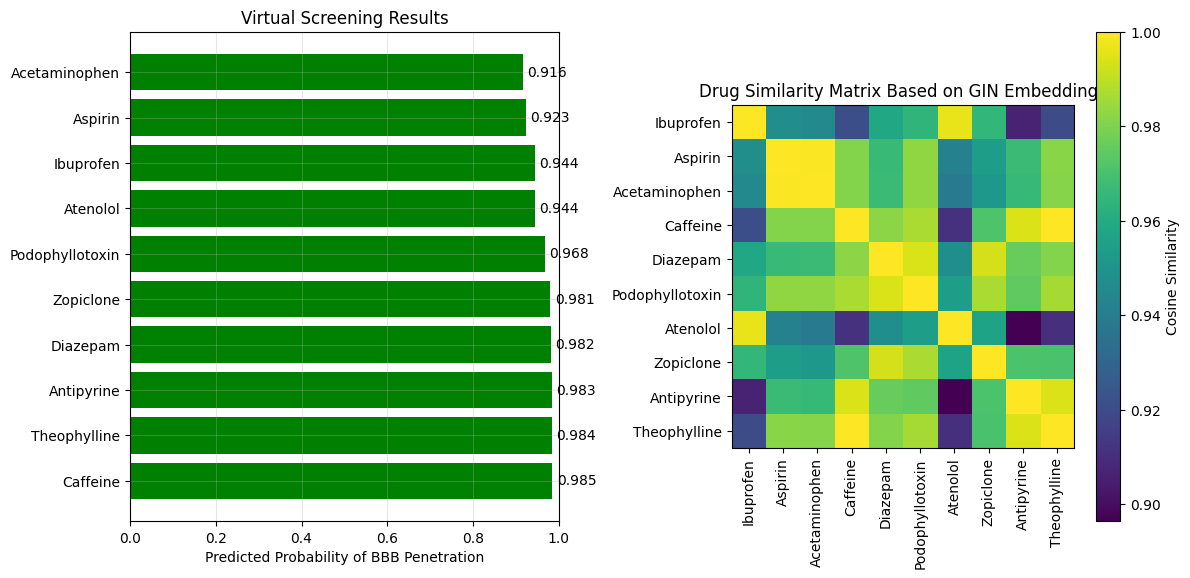

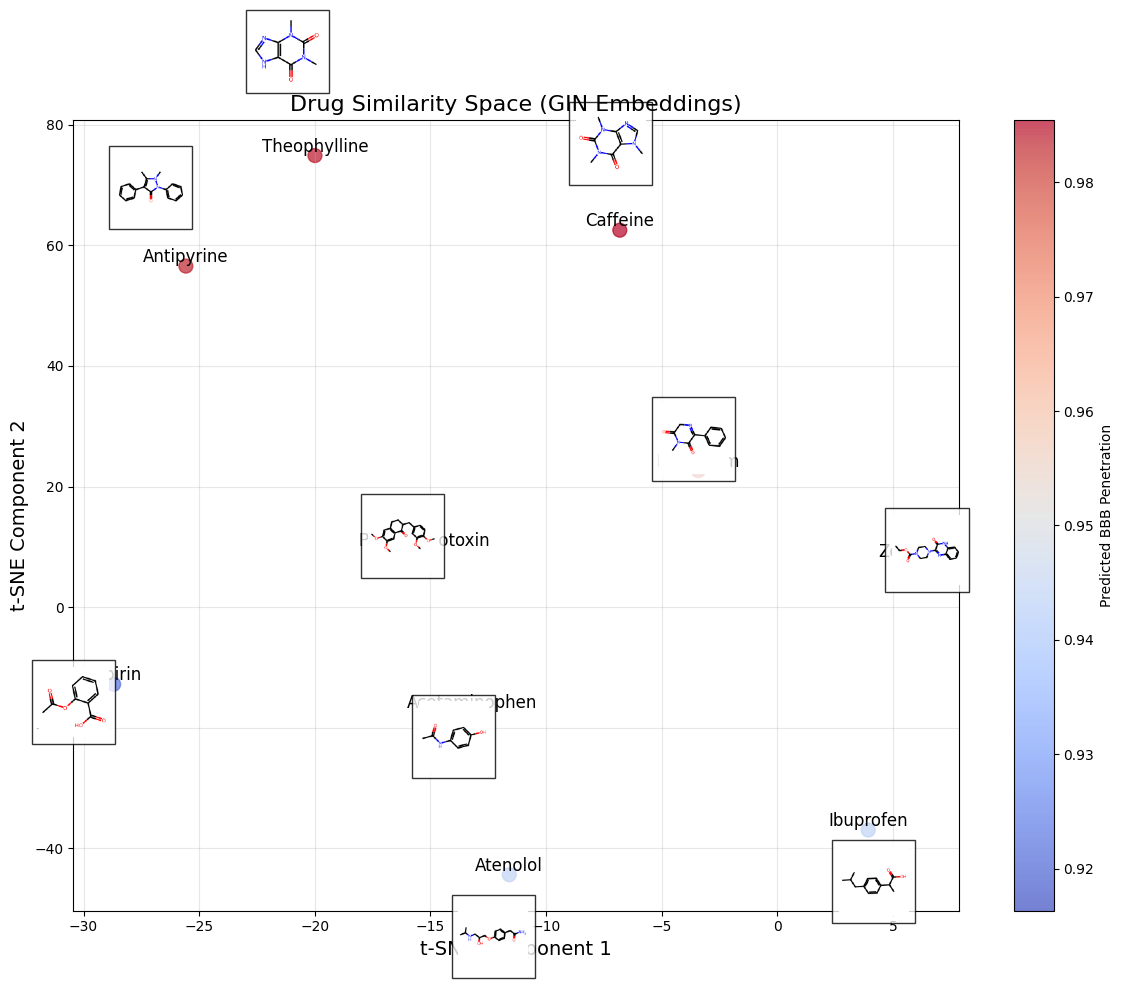

In [ ]:
def virtual_screening_demo():
    """Demonstrate a simple virtual screening workflow using GIN"""
    # Load a small library of drug-like molecules
    drug_smiles = [
        "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O",  # Ibuprofen
        "CC(=O)OC1=CC=CC=C1C(=O)O",      # Aspirin
        "CC(=O)NC1=CC=C(C=C1)O",         # Acetaminophen
        "CN1C=NC2=C1C(=O)N(C(=O)N2C)C",  # Caffeine
        "CN1C(=O)CN=C(C2=CC=CC=C2)C1=O", # Diazepam
        "COC1=CC2=C(C=C1OC)C(=O)C(CC2)CC3=CC(=C(C=C3)OC)OC", # Podophyllotoxin
        "CC(C)NCC(O)COC1=CC=C(C=C1)CC(=O)N", # Atenolol
        "CCOC(=O)N1CCN(CC1)C2=NC3=CC=CC=C3NC2=O", # Zopiclone
        "CC1=C(C(=O)N(N1C)C2=CC=CC=C2)C3=CC=CC=C3", # Antipyrine
        "CN1C2=C(C(=O)N(C1=O)C)NC=N2"   # Theophylline
    ]

    drug_names = [
        "Ibuprofen", "Aspirin", "Acetaminophen", "Caffeine", "Diazepam",
        "Podophyllotoxin", "Atenolol", "Zopiclone", "Antipyrine", "Theophylline"
    ]

    # Generate embeddings for each drug
    gin_model.eval()
    embeddings = []
    valid_indices = []

    for i, smiles in enumerate(drug_smiles):
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue

        data = mol_to_graph(smiles)
        data = data.to(device)

        with torch.no_grad():
            node_embeddings = gin_model.get_embeddings(data.x, data.edge_index,
                                                   torch.zeros(data.x.size(0), dtype=torch.long, device=device))
            graph_embedding = global_mean_pool(node_embeddings[-1],
                                           torch.zeros(data.x.size(0), dtype=torch.long, device=device))

        embeddings.append(graph_embedding.cpu().numpy())
        valid_indices.append(i)

    if embeddings:
        embeddings = np.vstack(embeddings)
        valid_drug_names = [drug_names[i] for i in valid_indices]
        valid_drug_smiles = [drug_smiles[i] for i in valid_indices]

        # Predict BBB permeability for each drug
        predictions = []

        for i, smiles in enumerate(valid_drug_smiles):
            data = mol_to_graph(smiles).to(device)

            with torch.no_grad():
                out = gin_model(data.x, data.edge_index, torch.zeros(data.x.size(0), dtype=torch.long, device=device))
                prob = torch.sigmoid(out).item()
                predictions.append(prob)

        # Visualize results
        plt.figure(figsize=(12, 6))

        # Sort by predicted probability
        sorted_indices = np.argsort(predictions)[::-1]
        sorted_names = [valid_drug_names[i] for i in sorted_indices]
        sorted_probs = [predictions[i] for i in sorted_indices]

        # Plot predictions
        plt.subplot(1, 2, 1)
        bars = plt.barh(sorted_names, sorted_probs, color=['green' if p > 0.5 else 'red' for p in sorted_probs])
        plt.xlabel('Predicted Probability of BBB Penetration')
        plt.title('Virtual Screening Results')
        plt.xlim(0, 1)
        plt.grid(True, alpha=0.3)

        # Add values
        for i, bar in enumerate(bars):
            plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                    f'{sorted_probs[i]:.3f}', va='center')

        # Calculate similarity matrix
        similarity_matrix = np.zeros((len(embeddings), len(embeddings)))
        for i in range(len(embeddings)):
            for j in range(len(embeddings)):
                similarity_matrix[i, j] = np.dot(embeddings[i], embeddings[j]) / (
                    np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[j]))

        # Plot similarity matrix
        plt.subplot(1, 2, 2)
        im = plt.imshow(similarity_matrix, cmap='viridis')
        plt.colorbar(im, label='Cosine Similarity')
        plt.title('Drug Similarity Matrix Based on GIN Embeddings')
        plt.xticks(range(len(valid_drug_names)), valid_drug_names, rotation=90)
        plt.yticks(range(len(valid_drug_names)), valid_drug_names)

        plt.tight_layout()
        plt.show()

        # Visualize molecules clustered by similarity
        # Reduce dimensionality for visualization
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(embeddings)-1))
        embeddings_2d = tsne.fit_transform(embeddings)

        plt.figure(figsize=(12, 10))

        # Plot embeddings
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                           c=predictions, cmap='coolwarm', s=100, alpha=0.7)
        plt.colorbar(scatter, label='Predicted BBB Penetration')

        # Add drug names as labels
        for i, name in enumerate(valid_drug_names):
            plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], name, fontsize=12,
                   ha='center', va='bottom')

            # Add molecule images
            mol = Chem.MolFromSmiles(valid_drug_smiles[i])

            if mol:
                img = Draw.MolToImage(mol, size=(100, 100))
                imagebox = OffsetImage(img, zoom=0.5)
                ab = AnnotationBbox(imagebox, (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                                  xycoords='data', boxcoords="offset points",
                                  box_alignment=(0.5, 0.5), pad=0.5,
                                  bboxprops=dict(facecolor='white', alpha=0.8))
                plt.gca().add_artist(ab)

        plt.title('Drug Similarity Space (GIN Embeddings)', fontsize=16)
        plt.xlabel('t-SNE Component 1', fontsize=14)
        plt.ylabel('t-SNE Component 2', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# Demonstrate virtual screening application
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
virtual_screening_demo()

## 12. Conclusion and Best Practices <a name="conclusion-and-best-practices"></a>

Let's summarize what we've learned about GIN and provide best practices for using it in molecular modeling:

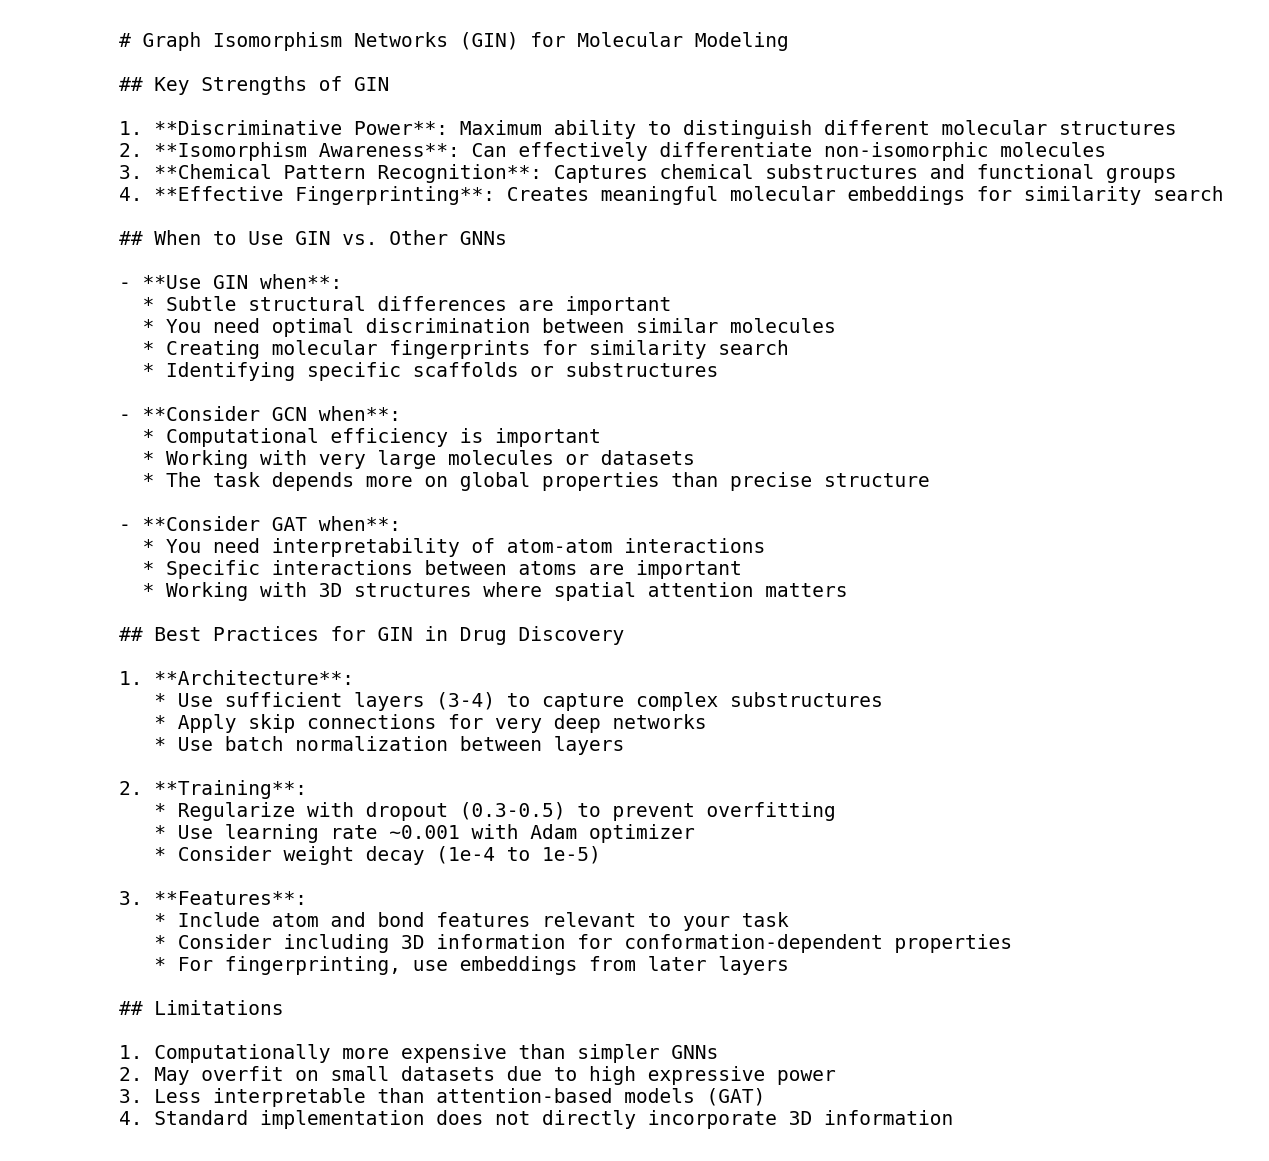

In [ ]:
def create_summary_visualization():
    """Create a visual summary of GIN for molecular modeling"""
    plt.figure(figsize=(14, 10))

    summary_text = """
    # Graph Isomorphism Networks (GIN) for Molecular Modeling

    ## Key Strengths of GIN

    1. **Discriminative Power**: Maximum ability to distinguish different molecular structures
    2. **Isomorphism Awareness**: Can effectively differentiate non-isomorphic molecules
    3. **Chemical Pattern Recognition**: Captures chemical substructures and functional groups
    4. **Effective Fingerprinting**: Creates meaningful molecular embeddings for similarity search

    ## When to Use GIN vs. Other GNNs

    - **Use GIN when**:
      * Subtle structural differences are important
      * You need optimal discrimination between similar molecules
      * Creating molecular fingerprints for similarity search
      * Identifying specific scaffolds or substructures

    - **Consider GCN when**:
      * Computational efficiency is important
      * Working with very large molecules or datasets
      * The task depends more on global properties than precise structure

    - **Consider GAT when**:
      * You need interpretability of atom-atom interactions
      * Specific interactions between atoms are important
      * Working with 3D structures where spatial attention matters

    ## Best Practices for GIN in Drug Discovery

    1. **Architecture**:
       * Use sufficient layers (3-4) to capture complex substructures
       * Apply skip connections for very deep networks
       * Use batch normalization between layers

    2. **Training**:
       * Regularize with dropout (0.3-0.5) to prevent overfitting
       * Use learning rate ~0.001 with Adam optimizer
       * Consider weight decay (1e-4 to 1e-5)

    3. **Features**:
       * Include atom and bond features relevant to your task
       * Consider including 3D information for conformation-dependent properties
       * For fingerprinting, use embeddings from later layers

    ## Limitations

    1. Computationally more expensive than simpler GNNs
    2. May overfit on small datasets due to high expressive power
    3. Less interpretable than attention-based models (GAT)
    4. Standard implementation does not directly incorporate 3D information
    """

    plt.text(0.05, 0.5, summary_text, fontsize=14,
            verticalalignment='center', horizontalalignment='left',
            family='monospace', transform=plt.gca().transAxes)

    plt.axis('off')
    plt.tight_layout()
    plt.show()

create_summary_visualization()

This concludes our comprehensive tutorial on Graph Isomorphism Networks (GIN) for chemists and pharmacists. We've covered the theoretical foundations, implementation details, and practical applications of GIN, particularly in the context of molecular modeling and drug discovery.

Key takeaways include:
1. The unique theoretical power of GIN in distinguishing molecular structures
2. How to implement and train GIN models for molecular property prediction
3. Using GIN for molecular fingerprinting and similarity search
4. The ability of GIN to capture chemical patterns and substructures
5. Practical applications in drug discovery workflows

We hope this tutorial helps you understand and apply GIN in your chemical and pharmaceutical research! '# Graph Isomorphism Networks (GIN) Tutorial for Chemists and Pharmacists